# Fitbit Data Analysis - Complete Enhanced Version

## Step 1: Install and Import Required Packages

In [128]:
print("STEP 1: Installing and importing required packages...")

STEP 1: Installing and importing required packages...


In [129]:
%pip install pandas matplotlib seaborn networkx scikit-learn imbalanced-learn numpy

In [130]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                            confusion_matrix, precision_recall_fscore_support,
                            precision_recall_curve, roc_curve,
                            auc, precision_score,
                            recall_score, f1_score)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

In [131]:
print("All packages successfully imported!\n")

All packages successfully imported!



## Step 2: Load and Prepare Data

In [132]:
print("STEP 2: Loading and preparing data...")

STEP 2: Loading and preparing data...


In [133]:
path = "../datas/Data Coaching Fitbit/"
files = glob.glob(os.path.join(path, "*.csv"))

In [134]:
print(f"Found {len(files)} CSV files in directory")

Found 7 CSV files in directory


In [135]:
dfs = []

for file in files:
    print(f"Processing file: {os.path.basename(file)}")
    df = pd.read_csv(file)
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['date'].dt.weekday < 5]  # Keep only weekdays
    df = df[df['date'].dt.hour <= 18]   # Keep only records before 18:00
    dfs.append(df)

Processing file: 1119.csv
Processing file: 1120.csv
Processing file: 1121.csv
Processing file: 1122.csv
Processing file: 1123.csv
Processing file: 1124.csv
Processing file: 1125.csv


In [136]:
# Combine DataFrames
df = pd.concat(dfs, ignore_index=True)

In [137]:
print("\n" + "="*50)
print("DATA SUMMARY".center(50))
print("="*50)

# Basic info
print(f"\n\033[1mFinal Dataset Shape:\033[0m {df.shape[0]} rows × {df.shape[1]} columns")

# Display samples
print("\n\033[1mFirst 5 rows:\033[0m")
print(df.head().to_string())
print("\n\033[1mLast 5 rows:\033[0m")
print(df.tail().to_string())

# Data types overview
print("\n\033[1mData Types:\033[0m")
print(df.dtypes.to_string())

# Statistical summary
print("\n\033[1mStatistical Summary:\033[0m")
print(df.describe(include='all').to_string())

# Missing values analysis
missing_values = df.isnull().sum()
missing_pct = (missing_values / len(df)) * 100
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_pct.round(2)
})
print("\n\033[1mMissing Values Analysis:\033[0m")
print(missing_info[missing_info['Missing Values'] > 0].sort_values('Percentage (%)', ascending=False).to_string())

# Duplicates analysis
duplicates = df.duplicated().sum()
duplicate_pct = (duplicates / len(df)) * 100
print(f"\n\033[1mDuplicate Rows:\033[0m {duplicates} ({duplicate_pct:.2f}%)")

# Column list
print("\n\033[1mColumns:\033[0m")
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")

print("\nData preparation complete!\n")


                   DATA SUMMARY                   

Final Dataset Shape: 1044240 rows × 8 columns

First 5 rows:
   treatment_id  fitbit_id                date  calories  mets  level  steps  distance
0          1119        329 2014-12-01 00:00:00    1.3822    10      0    0.0       0.0
1          1119        329 2014-12-01 00:01:00    1.3822    10      0    0.0       0.0
2          1119        329 2014-12-01 00:02:00    1.3822    10      0    0.0       0.0
3          1119        329 2014-12-01 00:03:00    1.3822    10      0    0.0       0.0
4          1119        329 2014-12-01 00:04:00    1.3822    10      0    0.0       0.0

Last 5 rows:
         treatment_id  fitbit_id                date  calories  mets  level  steps  distance
1044235          1125        328 2015-03-19 18:55:00   9.08136    72      3  110.0   0.08492
1044236          1125        328 2015-03-19 18:56:00   8.57684    68      3  103.0   0.07952
1044237          1125        328 2015-03-19 18:57:00   8.82910    70   

## Step 3: Exploratory Data Analysis

In [138]:
print("STEP 3: Performing exploratory data analysis...")

STEP 3: Performing exploratory data analysis...


### Plot 1: Individual Activity Analysis

In [139]:
def plot_person_data(treatment_id, df):
    """
    Plots activity metrics for a single person in a 2x2 grid
    """
    plot_config = [
        {'x': 'date', 'y': 'steps', 'type': 'line', 'color': None,
            'title': 'Steps Over Time', 'ylabel': 'Steps', 'xlabel': 'Date'},
        {'x': 'date', 'y': 'calories', 'type': 'line', 'color': 'red',
            'title': 'Calories Burned Over Time', 'ylabel': 'Calories', 'xlabel': 'Date'},
        {'x': 'date', 'y': 'distance', 'type': 'line', 'color': 'green',
            'title': 'Distance Over Time', 'ylabel': 'Distance (km)', 'xlabel': 'Date'},
        {'x': 'date', 'y': 'mets', 'type': 'line', 'color': 'purple',
            'title': 'METs Over Time', 'ylabel': 'METs', 'xlabel': 'Date'}
    ]

    n_plots = len(plot_config)
    n_rows = int(np.ceil(n_plots / 2))

    fig, axes = plt.subplots(n_rows, min(2, n_plots), figsize=(12, 10))
    axes = axes.flatten() if n_plots > 1 else [axes]
    fig.suptitle(f'Activity Data for Person {treatment_id}')

    for ax, config in zip(axes, plot_config):

        ax.plot(df[config['x']], df[config['y']],
                marker=config.get('marker', 'o'),
                linestyle=config.get('linestyle', '-'),
                color=config.get('color'),
                label=config.get('label'))

        ax.set_title(config.get('title', ''))
        ax.set_xlabel(config.get('xlabel', ''))
        ax.set_ylabel(config.get('ylabel', ''))

        if 'xticklabels' in config:
            ax.set_xticklabels(config['xticklabels'], rotation=45)

        if config.get('legend'):
            ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

Plotting data for user 1119


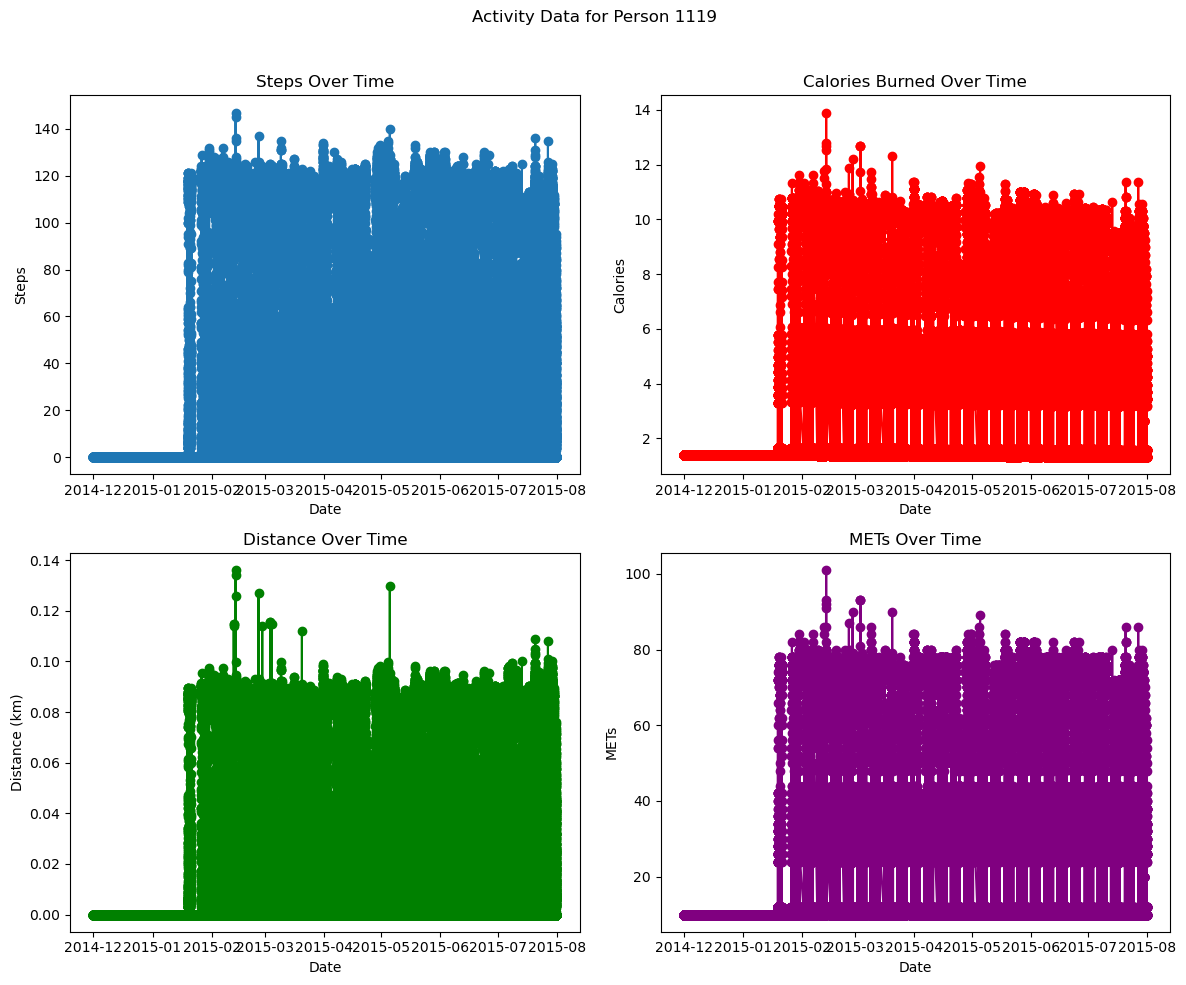

Plotting data for user 1120


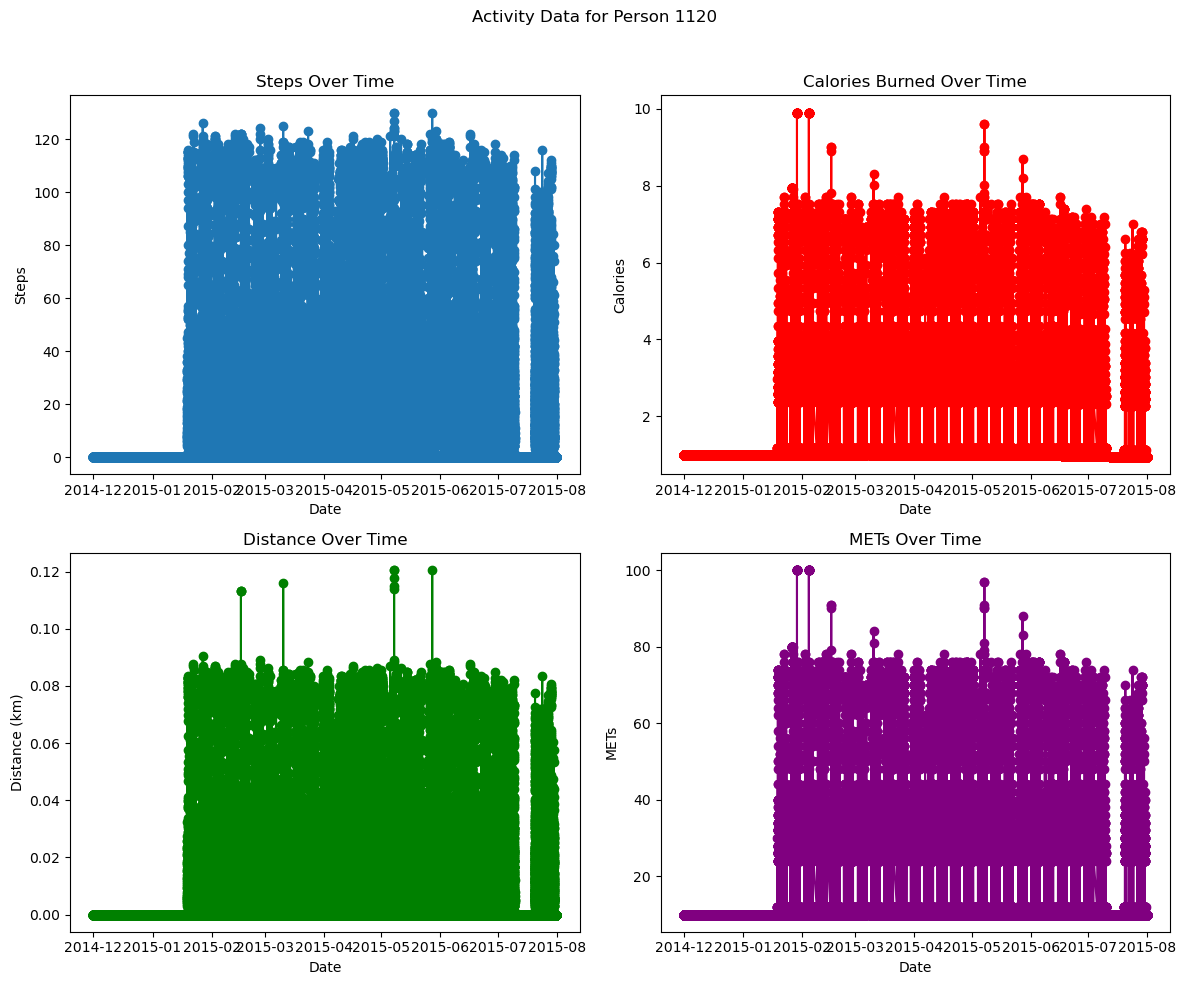

Plotting data for user 1121


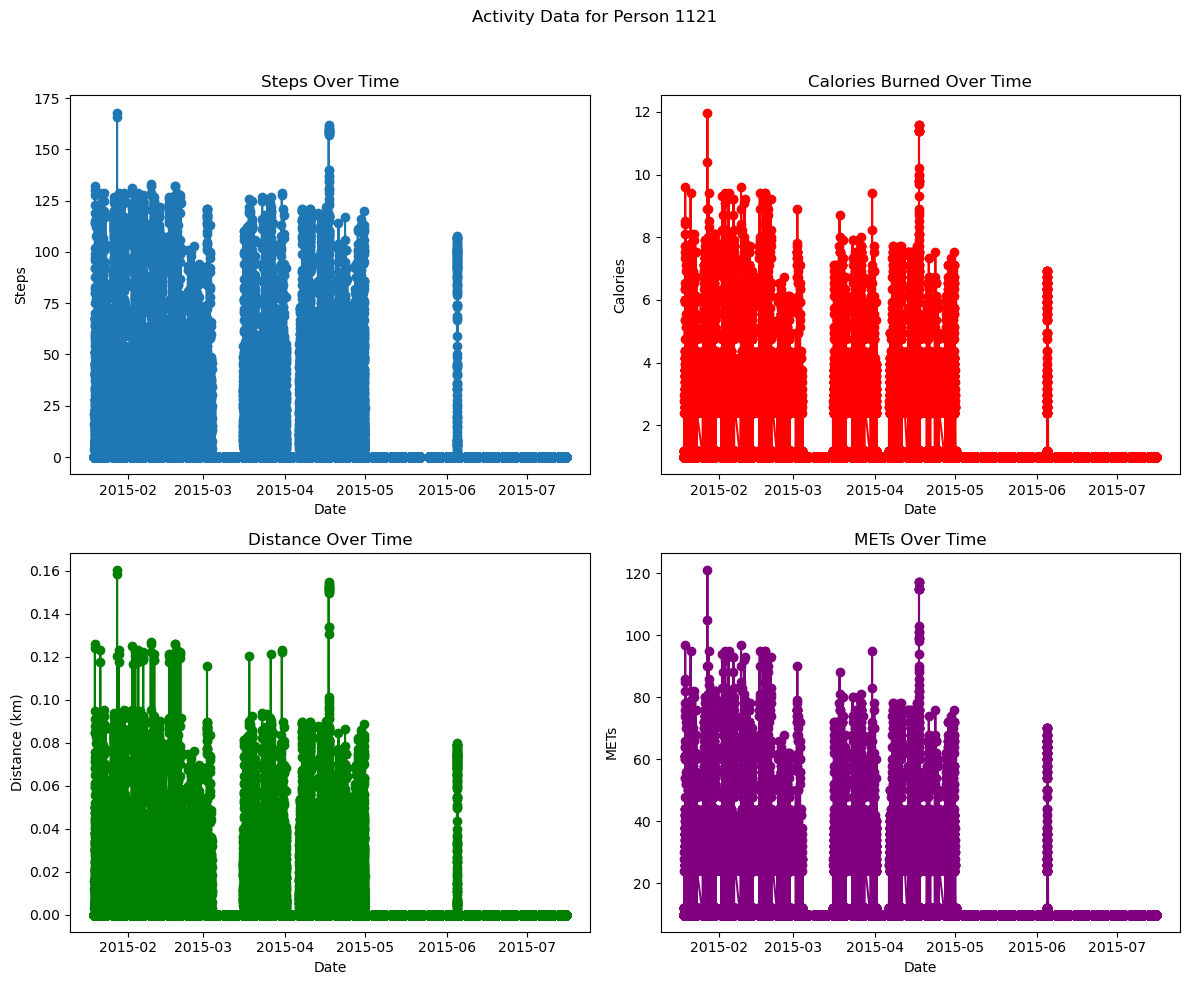

Plotting data for user 1122


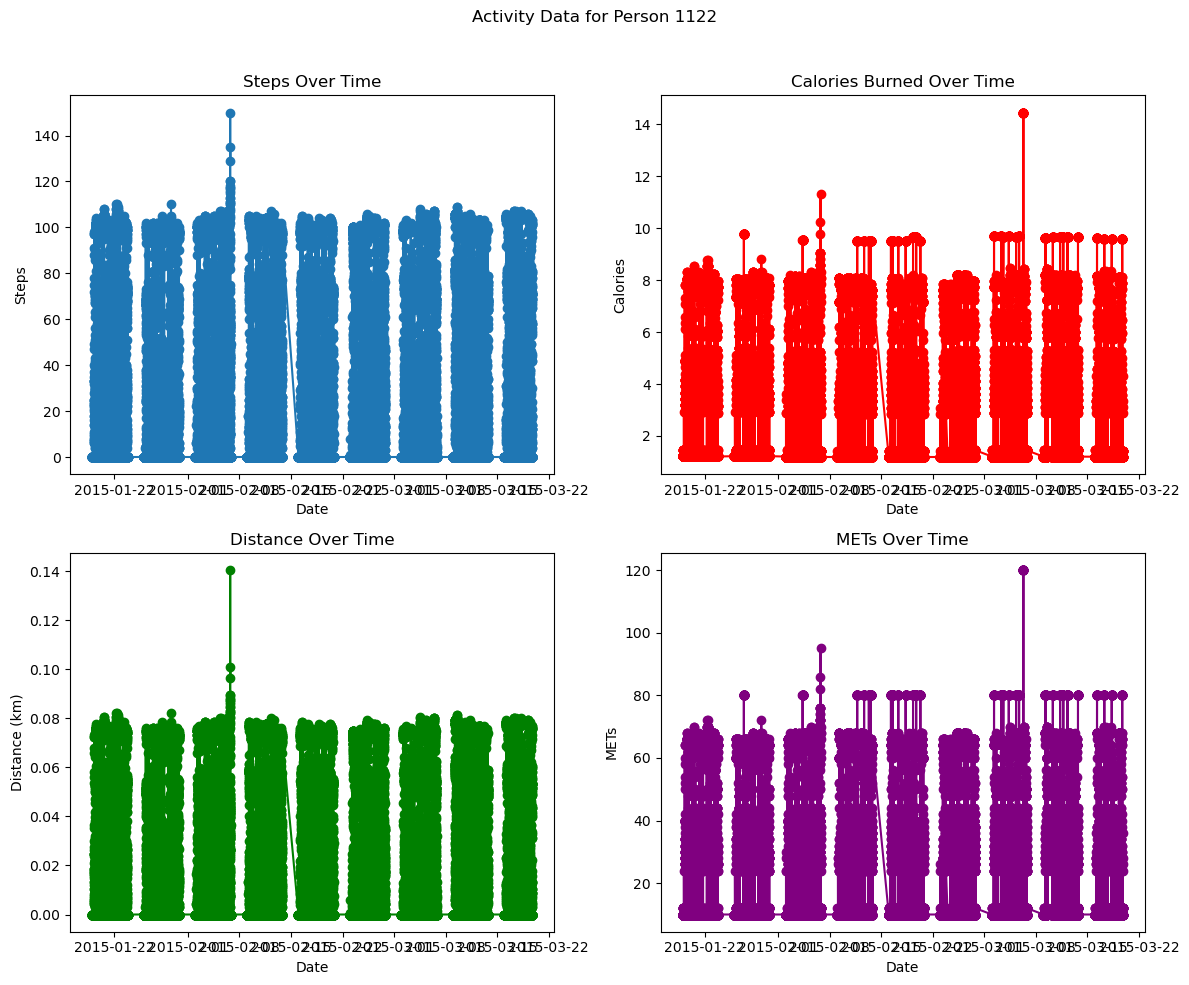

Plotting data for user 1123


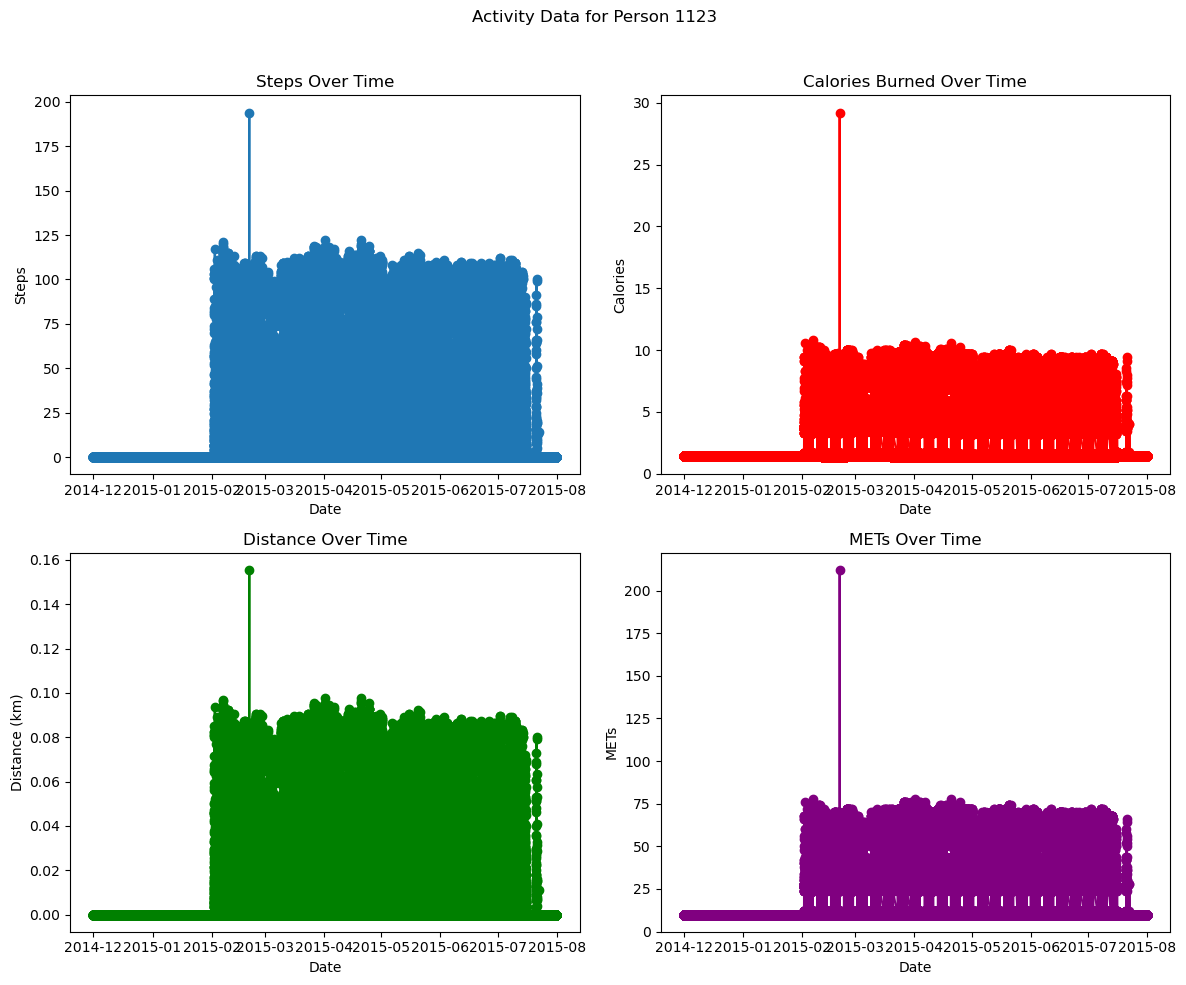

Plotting data for user 1124


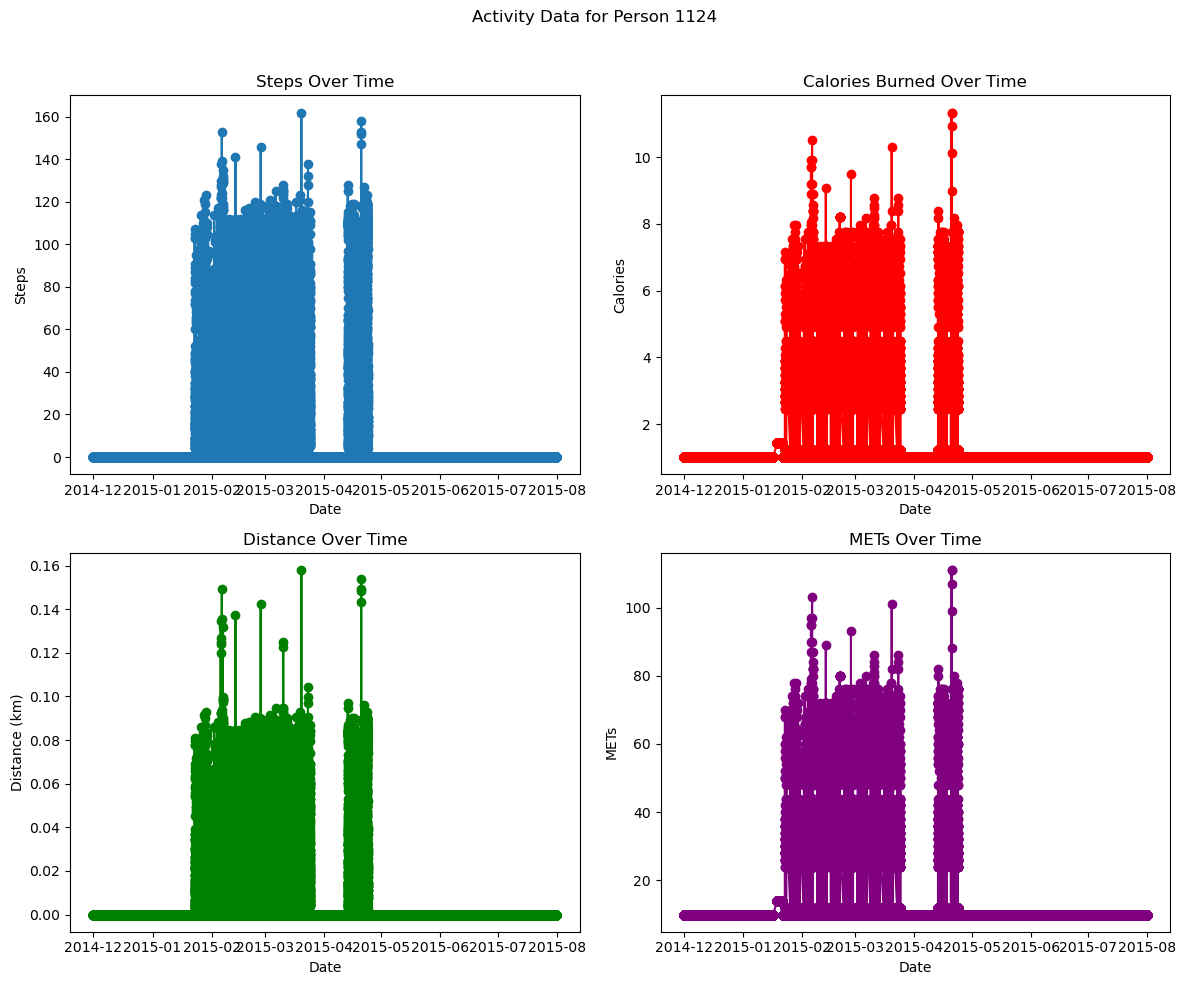

Plotting data for user 1125


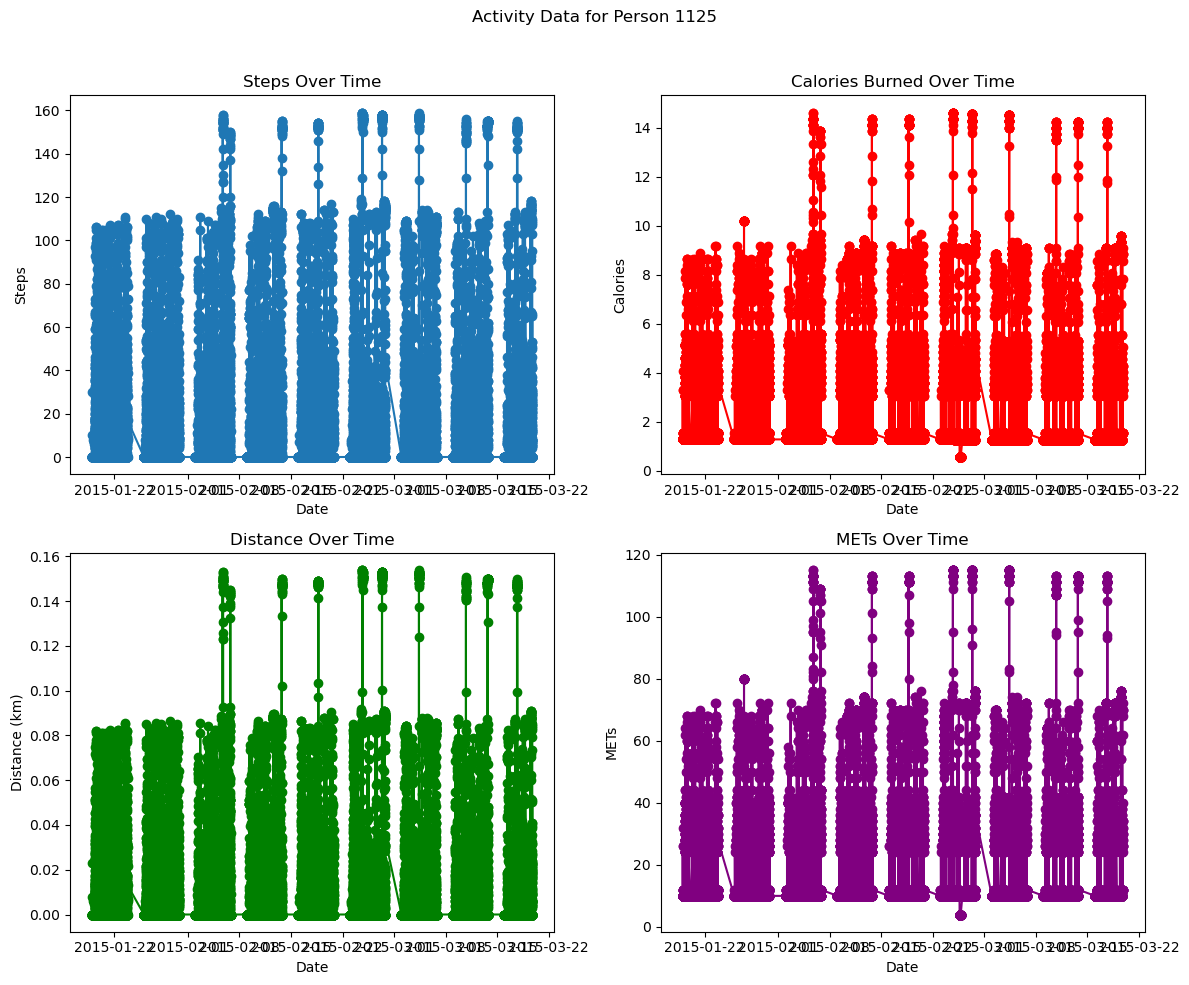

In [140]:
for treatment_id, person_df in df.groupby("treatment_id"):
    print(f"Plotting data for user {treatment_id}")

    # For individual person view
    plot_person_data(treatment_id, person_df)

### Plot 2: Group Comparison

In [141]:
def plot_group_comparison(df):
    df_summary = df.groupby("treatment_id").agg({
        "steps": "mean",
        "calories": "mean",
        "distance": "mean",
        "mets": "mean"
    }).rename(columns={
        "steps": "Avg Steps",
        "calories": "Avg Calories",
        "distance": "Avg Distance",
        "mets": "Avg METs"
    })

    plot_config = [
        {'y': 'Avg Steps', 'type': 'bar', 'color': 'blue',
            'title': 'Average Steps', 'ylabel': 'Steps', 'xlabel': 'User ID'},
        {'y': 'Avg Calories', 'type': 'bar', 'color': 'red',
            'title': 'Average Calories', 'ylabel': 'Calories', 'xlabel': 'User ID'},
        {'y': 'Avg Distance', 'type': 'bar', 'color': 'green',
            'title': 'Average Distance', 'ylabel': 'Distance (km)', 'xlabel': 'User ID'},
        {'y': 'Avg METs', 'type': 'bar', 'color': 'purple',
            'title': 'Average METs', 'ylabel': 'METs', 'xlabel': 'User ID',
            'xticklabels': df_summary.index}
    ]

    n_plots = len(plot_config)
    n_rows = int(np.ceil(n_plots / 2))

    fig, axes = plt.subplots(n_rows, min(2, n_plots), figsize=(12, 10))
    axes = axes.flatten() if n_plots > 1 else [axes]

    fig.suptitle("Comparison of Activity Metrics Across Users")

    for ax, config in zip(axes, plot_config):

        df_summary[config['y']].plot(kind='bar', ax=ax,
                                    color=config.get('color'),
                                    label=config.get('label'))

        ax.set_title(config.get('title', ''))
        ax.set_xlabel(config.get('xlabel', ''))
        ax.set_ylabel(config.get('ylabel', ''))

        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

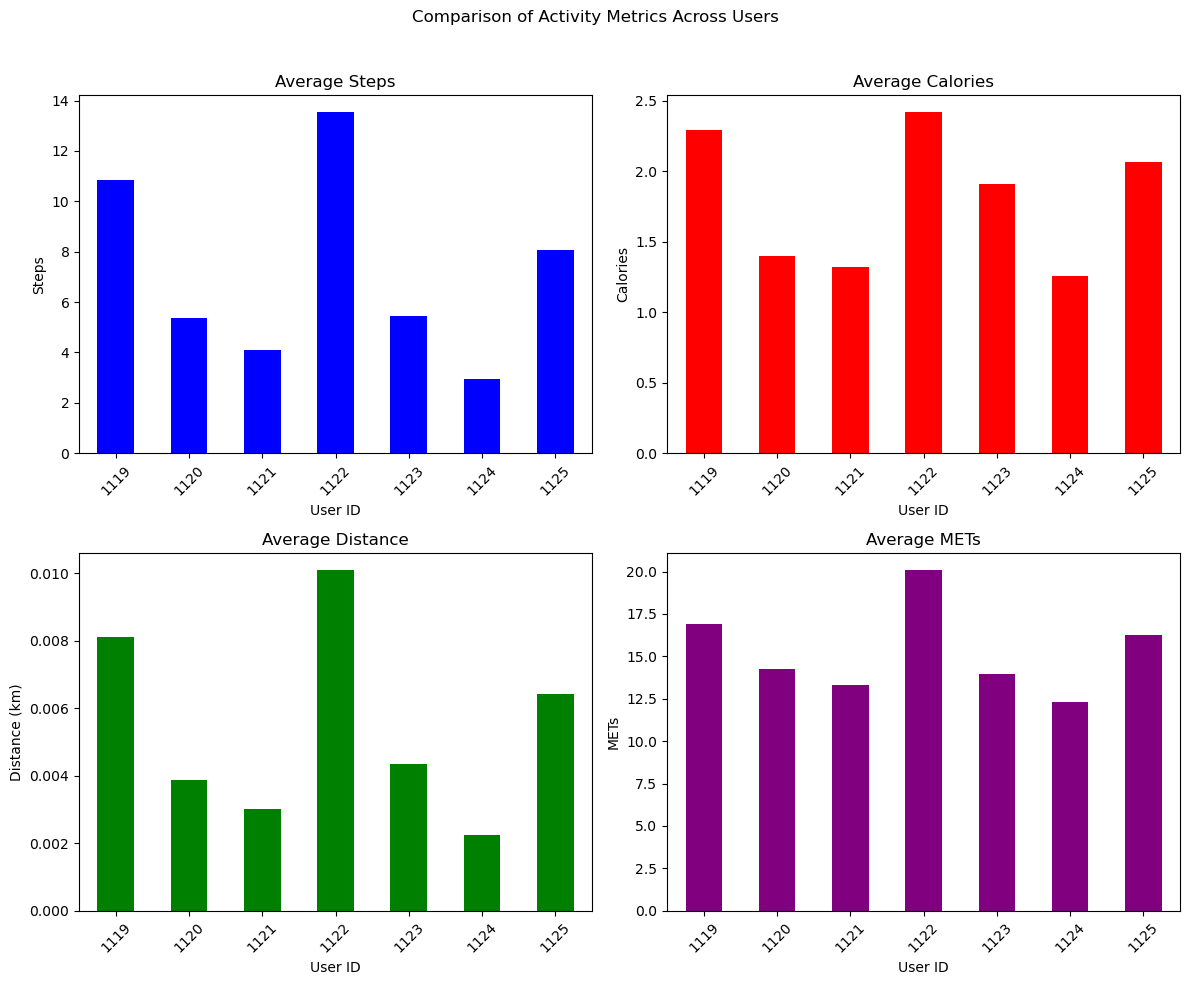

In [142]:
plot_group_comparison(df)

### Plot 3: Individual means

In [143]:
# Compute individual means for steps
individual_means = df.groupby(['treatment_id', df['date'].dt.date])['steps'].mean().reset_index()

In [144]:
# Convert 'date' back to datetime format
individual_means['date'] = pd.to_datetime(individual_means['date'])

In [145]:
treatment_ids = individual_means['treatment_id'].unique()

In [146]:
def show_individual_mean_plots(data, treatment_column='treatment_id', date_column='date', value_column='steps', 
                                fig_size=(12, 6), title_prefix="Individual Mean Steps for Treatment", 
                                x_label="Date", y_label="Average Steps", rotate_xticks=45, ci=None):
    """
    Plot individual mean values for each treatment group with regression lines.

    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame containing the data to plot
    treatment_column : str
        Column name containing treatment IDs
    date_column : str
        Column name containing dates
    value_column : str
        Column name containing the values to plot (e.g., steps)
    fig_size : tuple
        Figure size (width, height)
    title_prefix : str
        Prefix for plot titles
    x_label : str
        Label for x-axis
    y_label : str
        Label for y-axis
    rotate_xticks : int
        Rotation angle for x-axis tick labels
    ci : int or None
        Confidence interval for regression plot
    """
    # Get unique treatment IDs
    treatment_ids = data[treatment_column].unique()

    for treatment in treatment_ids:
        print(f"Plotting data for treatment {treatment}")

        # Filter data for the current treatment_id
        subset = data[data[treatment_column] == treatment].copy()

        # Convert date to numeric for regression
        subset.loc[:, 'date_numeric'] = (subset[date_column] - subset[date_column].min()).dt.days

        # Prepare x-ticks (first day of each month)
        months = pd.date_range(start=subset[date_column].min(),
                                end=subset[date_column].max(),
                                freq='MS')
        month_numeric = (months - subset[date_column].min()).days

        # Create figure
        fig, ax = plt.subplots(figsize=fig_size)

        # Plot regression line and scatter points
        sns.regplot(
            data=subset,
            x='date_numeric',
            y=value_column,
            scatter=True,
            ci=ci,
            label=f'Treatment {treatment}',
            ax=ax
        )

        # Set x-ticks
        ax.set_xticks(month_numeric)
        ax.set_xticklabels(months.strftime('%Y/%m'), rotation=rotate_xticks)

        # Set title and labels
        ax.set_title(f"{title_prefix} {treatment}")
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)

        # Show legend
        ax.legend()

        plt.tight_layout()
        plt.show()

Plotting data for treatment 1119


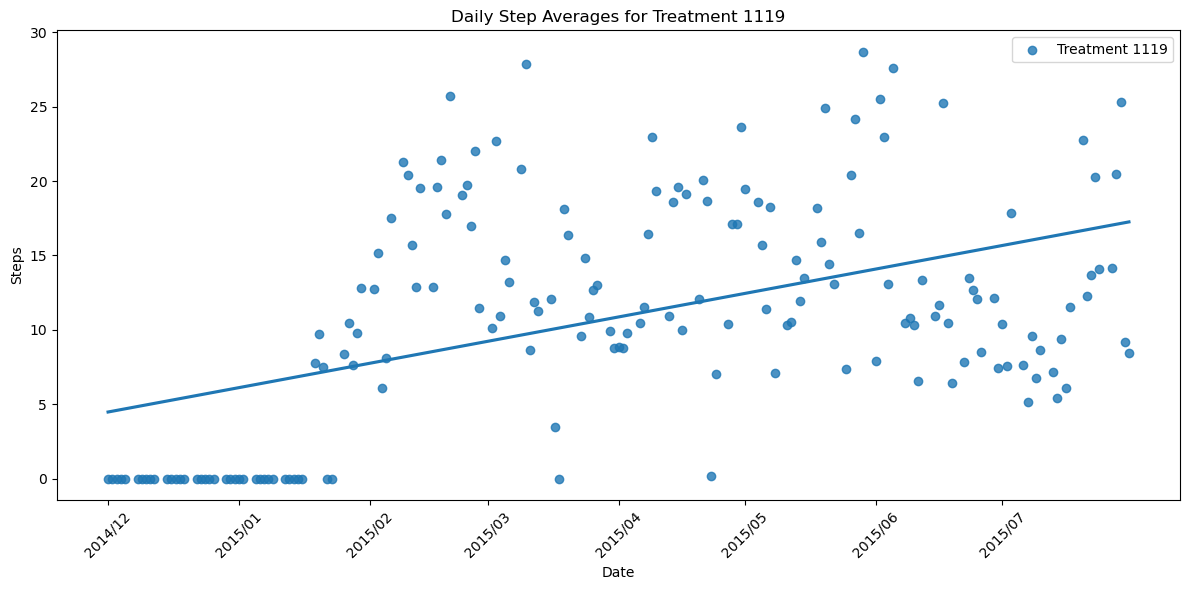

Plotting data for treatment 1120


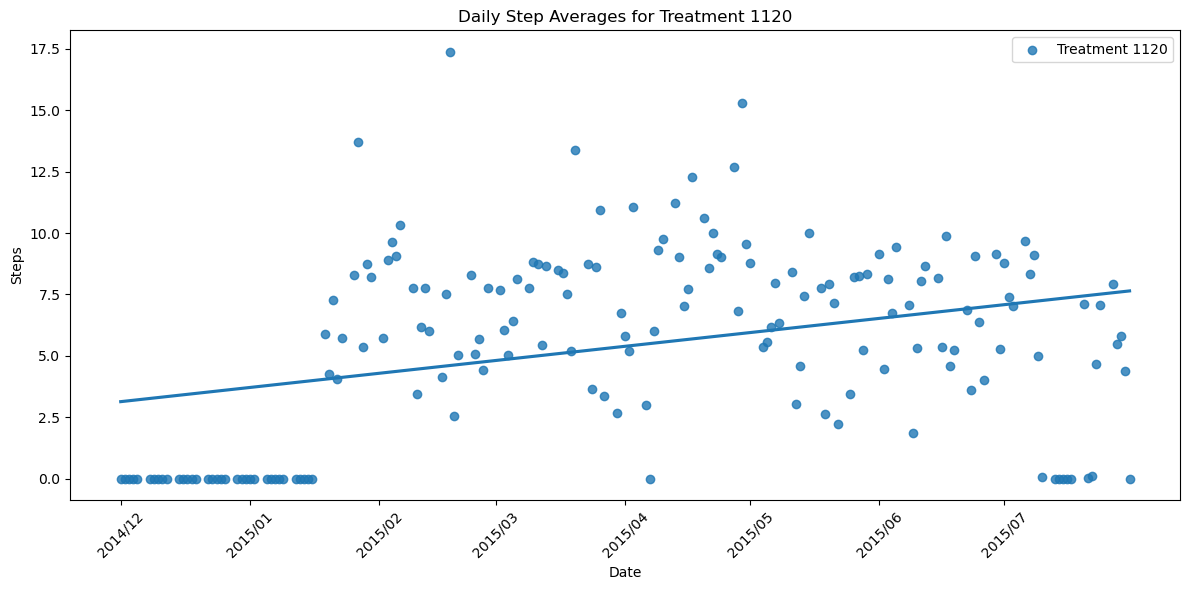

Plotting data for treatment 1121


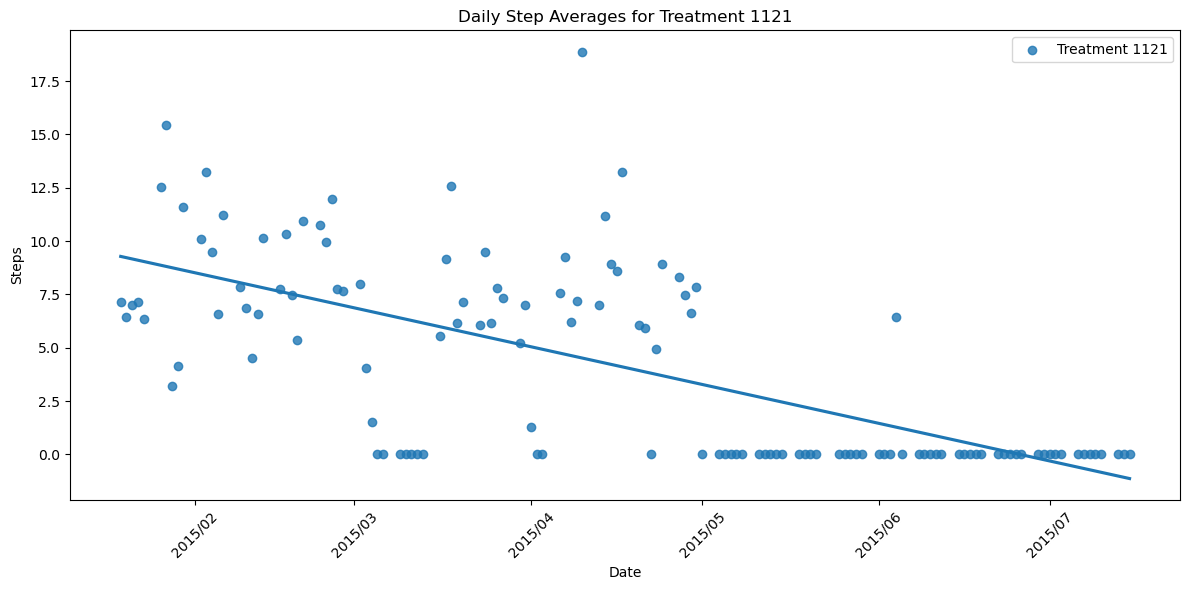

Plotting data for treatment 1122


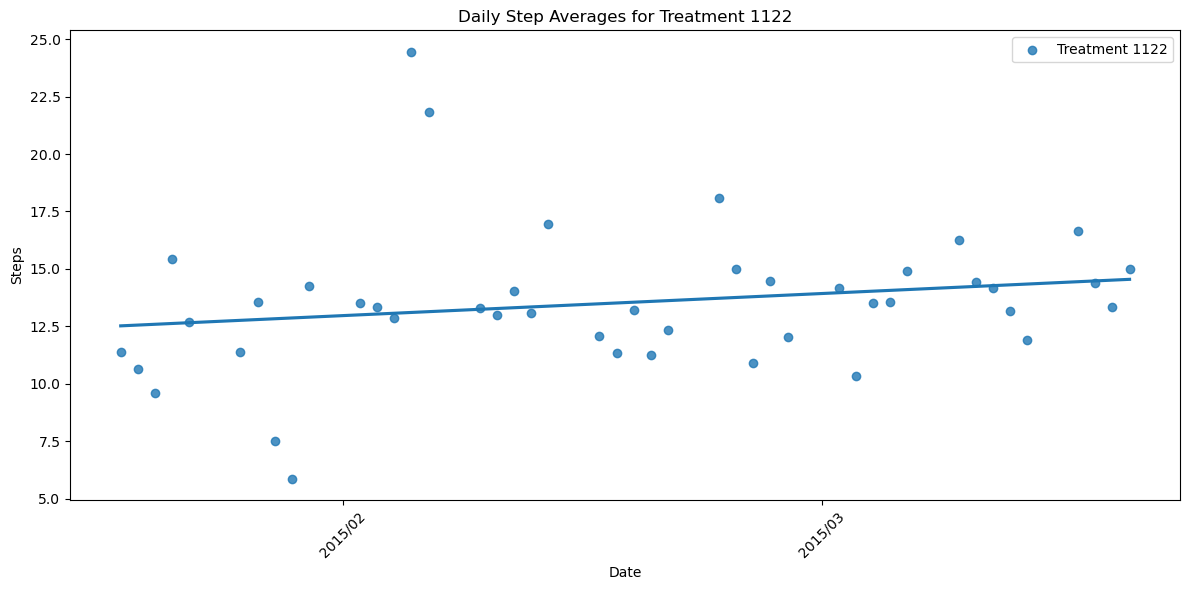

Plotting data for treatment 1123


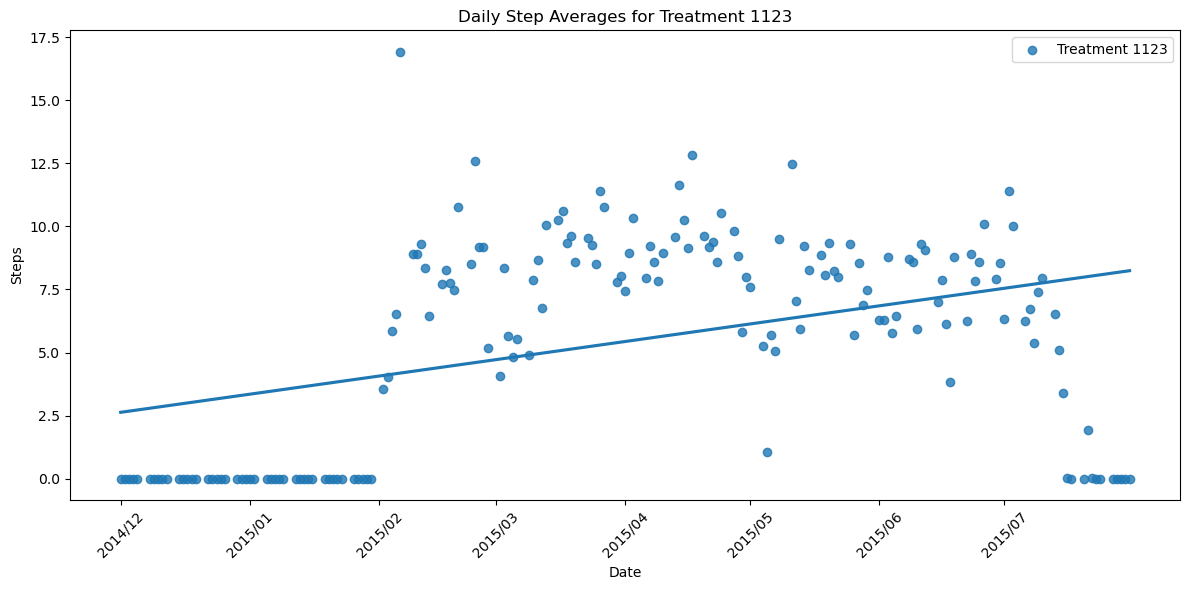

Plotting data for treatment 1124


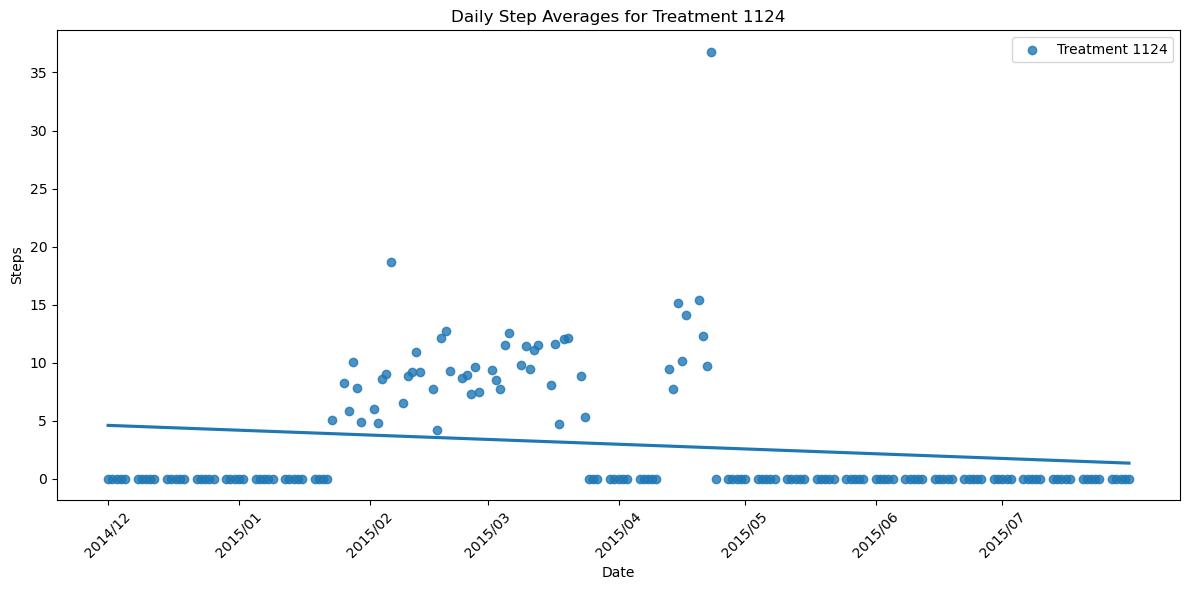

Plotting data for treatment 1125


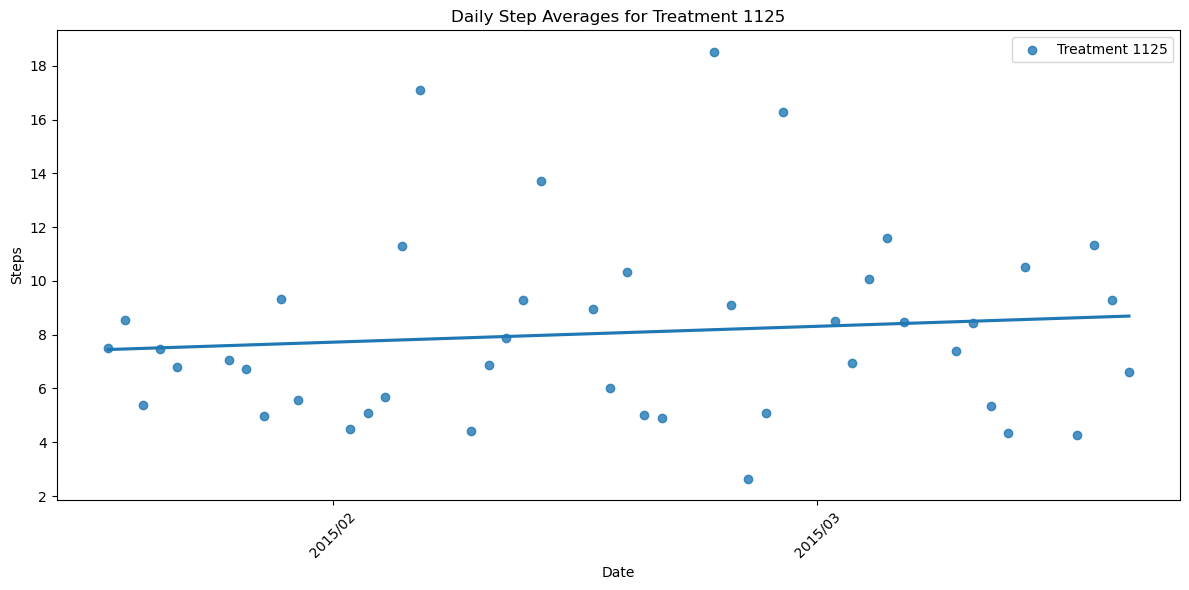

In [147]:
# Example usage
show_individual_mean_plots(
    data=individual_means,
    treatment_column='treatment_id',
    date_column='date',
    value_column='steps',
    title_prefix="Daily Step Averages for Treatment",
    x_label="Date",
    y_label="Steps",
    rotate_xticks=45,
    ci=None  # Set to 95 for confidence intervals
)

### Plot 4: Average steps

In [148]:
# Compute the average of all individuals' steps per day
average_steps = df.groupby([df['date'].dt.date])['steps'].mean().reset_index()

In [149]:
# Convert 'date' back to datetime format
average_steps['date'] = pd.to_datetime(average_steps['date'])

In [150]:
print("\n" + "="*50)
print("DATA SUMMARY".center(50))
print("="*50)

# Basic info
print(f"Final Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")

# Display samples
print("First 5 rows:")
print(df.head().to_string())
print("Last 5 rows:")
print(df.tail().to_string())

# Data types overview
print("Data Types:")
print(df.dtypes.to_string())

# Statistical summary
print("Statistical Summary:")
print(df.describe(include='all').to_string())

# Missing values analysis
missing_values = df.isnull().sum()
missing_pct = (missing_values / len(df)) * 100
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_pct.round(2)
})
print("Missing Values Analysis:")
print(missing_info[missing_info['Missing Values'] > 0].sort_values('Percentage (%)', ascending=False).to_string())

# Duplicates analysis
duplicates = df.duplicated().sum()
duplicate_pct = (duplicates / len(df)) * 100
print(f"Duplicate Rows: {duplicates} ({duplicate_pct:.2f}%)")

# Column list
print("Columns:")
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")

print("\nData preparation complete!\n")


                   DATA SUMMARY                   
Final Dataset Shape: 1044240 rows × 8 columns
First 5 rows:
   treatment_id  fitbit_id                date  calories  mets  level  steps  distance
0          1119        329 2014-12-01 00:00:00    1.3822    10      0    0.0       0.0
1          1119        329 2014-12-01 00:01:00    1.3822    10      0    0.0       0.0
2          1119        329 2014-12-01 00:02:00    1.3822    10      0    0.0       0.0
3          1119        329 2014-12-01 00:03:00    1.3822    10      0    0.0       0.0
4          1119        329 2014-12-01 00:04:00    1.3822    10      0    0.0       0.0
Last 5 rows:
         treatment_id  fitbit_id                date  calories  mets  level  steps  distance
1044235          1125        328 2015-03-19 18:55:00   9.08136    72      3  110.0   0.08492
1044236          1125        328 2015-03-19 18:56:00   8.57684    68      3  103.0   0.07952
1044237          1125        328 2015-03-19 18:57:00   8.82910    70      

In [151]:
# Calculate and print the average number of steps
overall_avg_steps = average_steps['steps'].mean()
print(f"Average number of steps: {overall_avg_steps:.2f} by minute")
print(f"Average number of steps: {overall_avg_steps * 60:.2f} by hour")
print(f"Average number of steps: {overall_avg_steps * 60 * 24:.2f} by day")

Average number of steps: 5.77 by minute
Average number of steps: 346.11 by hour
Average number of steps: 8306.60 by day


In [152]:
def show_average_number_of_steps(average_steps_per_person, overall_avg_steps, time_unit='minutes', 
                                fig_size=(10, 6), title_prefix="Average number of steps", 
                                x_label="User ID", y_label="Average Steps", legend=True):
    """
    Plot average steps per person with a reference line showing the overall average.

    Parameters:
    -----------
    average_steps_per_person : pd.Series
        Series with index as user IDs and values as average steps
    overall_avg_steps : float
        The overall average steps value (per minute)
    time_unit : str ('minutes', 'hours', 'days')
        The time unit to calculate and display steps for
    fig_size : tuple
        Figure size (width, height)
    title_prefix : str
        Prefix for the plot title
    x_label : str
        Label for x-axis
    y_label : str
        Label for y-axis
    legend : bool
        Whether to show the legend
    """
    # Calculate multiplier and time unit label
    multipliers = {
        'minutes': 1,
        'hours': 60,
        'days': 60 * 24
    }

    if time_unit not in multipliers:
        raise ValueError(f"time_unit must be one of {list(multipliers.keys())}")

    multiplier = multipliers[time_unit]
    scaled_avg = overall_avg_steps * multiplier

    # Create figure
    fig, ax = plt.subplots(figsize=fig_size)

    # Plot bar chart
    sns.barplot(
        x=average_steps_per_person.index,
        y=average_steps_per_person.values,
        ax=ax
    )

    # Add reference line
    ax.axhline(
        y=scaled_avg,
        color='red',
        linestyle='--',
        linewidth=1,
        label=f'Average steps: {scaled_avg:.1f}'
    )

    # Set title and labels
    ax.set_title(f"{title_prefix} by {time_unit} per person")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Rotate x-axis labels if many users
    if len(average_steps_per_person) > 10:
        plt.xticks(rotation=45)

    # Show legend if requested
    if legend:
        ax.legend()

    plt.tight_layout()
    plt.show()

In [153]:
# Calculate the average number of steps per person at 18:00 on a working day
average_steps_per_person = df.groupby('treatment_id')['steps'].mean()
print("Average number of steps by minutes per person at 18:00 on a working day:")
print(average_steps_per_person)

Average number of steps by minutes per person at 18:00 on a working day:
treatment_id
1119    10.864331
1120     5.387173
1121     4.116294
1122    13.529545
1123     5.436145
1124     2.957073
1125     8.067763
Name: steps, dtype: float64


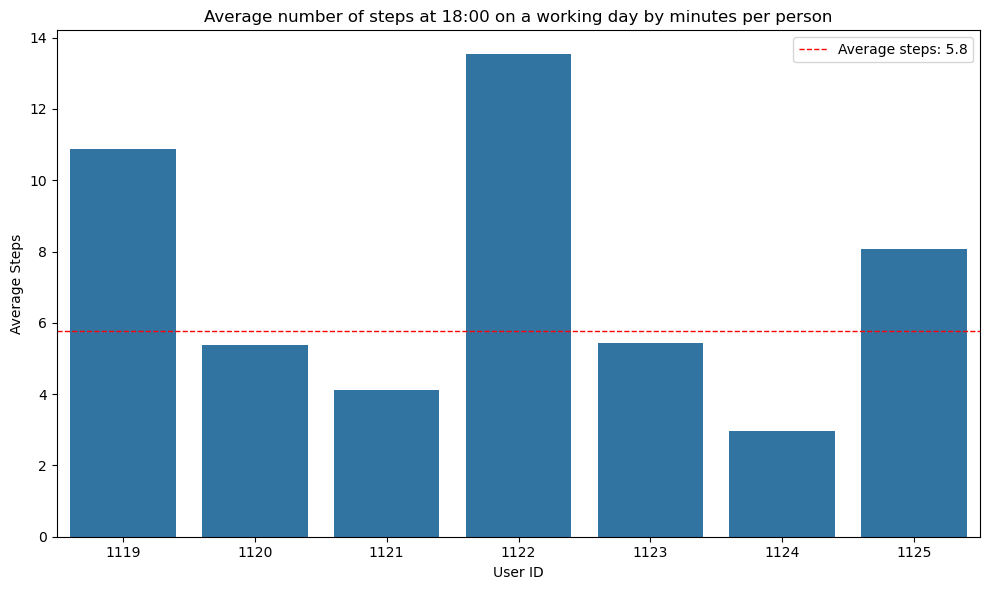

In [154]:
# For minutes
show_average_number_of_steps(
    average_steps_per_person=average_steps_per_person,
    overall_avg_steps=overall_avg_steps,
    time_unit='minutes',
    title_prefix="Average number of steps at 18:00 on a working day"
)

In [155]:
print("Average number of steps by hours per person at 18:00 on a working day:")
average_steps_per_person = average_steps_per_person * 60
print(average_steps_per_person)

Average number of steps by hours per person at 18:00 on a working day:
treatment_id
1119    651.859850
1120    323.230376
1121    246.977621
1122    811.772727
1123    326.168722
1124    177.424361
1125    484.065789
Name: steps, dtype: float64


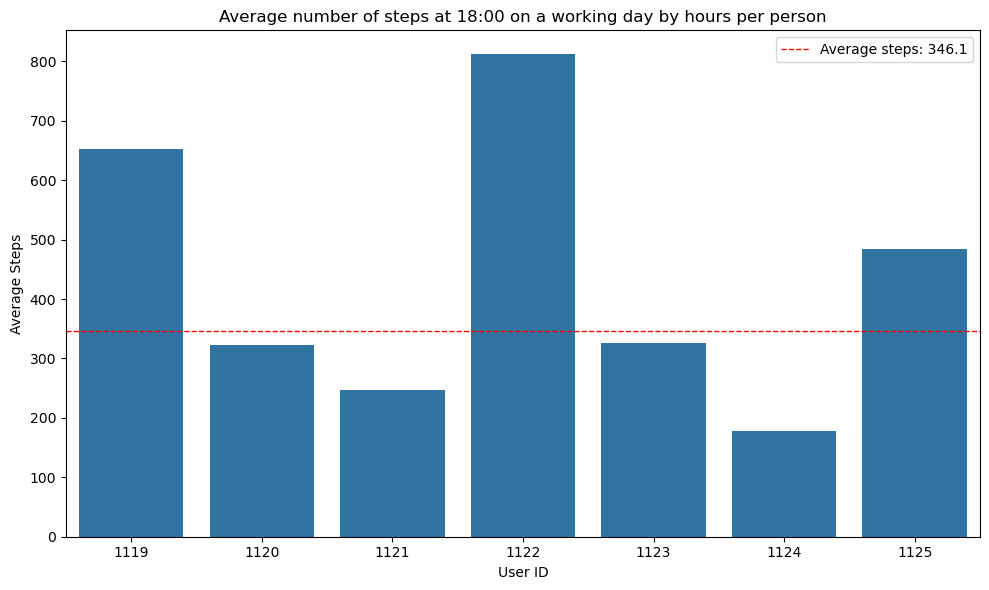

In [156]:
# For hours
show_average_number_of_steps(
    average_steps_per_person=average_steps_per_person,
    overall_avg_steps=overall_avg_steps,
    time_unit='hours',
    title_prefix="Average number of steps at 18:00 on a working day"
)

In [157]:
average_steps_per_person = average_steps_per_person * 24
print("Average number of steps by day per person at 18:00 on a working day:")
print(average_steps_per_person)

Average number of steps by day per person at 18:00 on a working day:
treatment_id
1119    15644.636391
1120     7757.529023
1121     5927.462909
1122    19482.545455
1123     7828.049323
1124     4258.184662
1125    11617.578947
Name: steps, dtype: float64


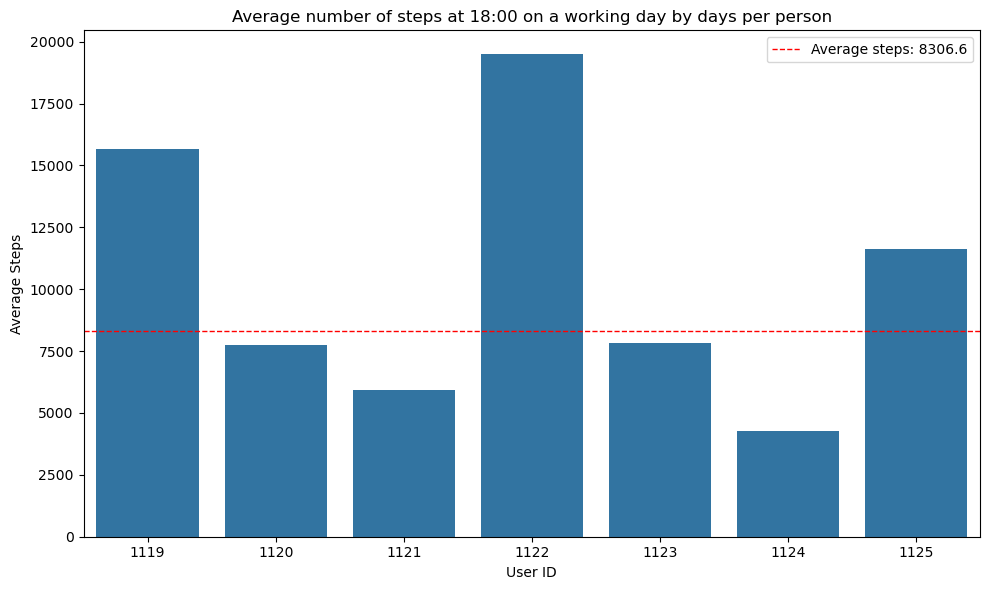

In [158]:
# For days
show_average_number_of_steps(
    average_steps_per_person=average_steps_per_person,
    overall_avg_steps=overall_avg_steps,
    time_unit='days',
    title_prefix="Average number of steps at 18:00 on a working day"
)

### Plot 5: Average steps for all treatment groups

In [159]:
def show_average_steps_trend(data, date_column='date', value_column='steps',
                            fig_size=(12, 6), title="Average Steps Trend",
                            x_label="Date", y_label="Average Steps",
                            rotate_xticks=45, ci=None, show_legend=True):
    """
    Plot average steps over time with regression line and monthly ticks.

    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame containing the time series data
    date_column : str
        Column name containing dates
    value_column : str
        Column name containing the values to plot (e.g., steps)
    fig_size : tuple
        Figure size (width, height)
    title : str
        Plot title
    x_label : str
        Label for x-axis
    y_label : str
        Label for y-axis
    rotate_xticks : int
        Rotation angle for x-axis tick labels
    ci : int or None
        Confidence interval for regression plot
    show_legend : bool
        Whether to show the legend
    """
    # Make a copy to avoid modifying original dataframe
    plot_data = data.copy()

    # Convert date to numeric for regression
    plot_data['date_numeric'] = (plot_data[date_column] - plot_data[date_column].min()).dt.days

    # Prepare x-ticks (first day of each month)
    months = pd.date_range(
        start=plot_data[date_column].min(),
        end=plot_data[date_column].max(),
        freq='MS'
    )
    month_numeric = (months - plot_data[date_column].min()).days

    # Create figure
    fig, ax = plt.subplots(figsize=fig_size)

    # Plot regression line and scatter points
    sns.regplot(
        data=plot_data,
        x='date_numeric',
        y=value_column,
        scatter=True,
        ci=ci,
        label='Average Steps',
        ax=ax
    )

    # Set x-ticks
    ax.set_xticks(month_numeric)
    ax.set_xticklabels(months.strftime('%Y/%m'), rotation=rotate_xticks)

    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Show legend if requested
    if show_legend:
        ax.legend()

    plt.tight_layout()
    plt.show()

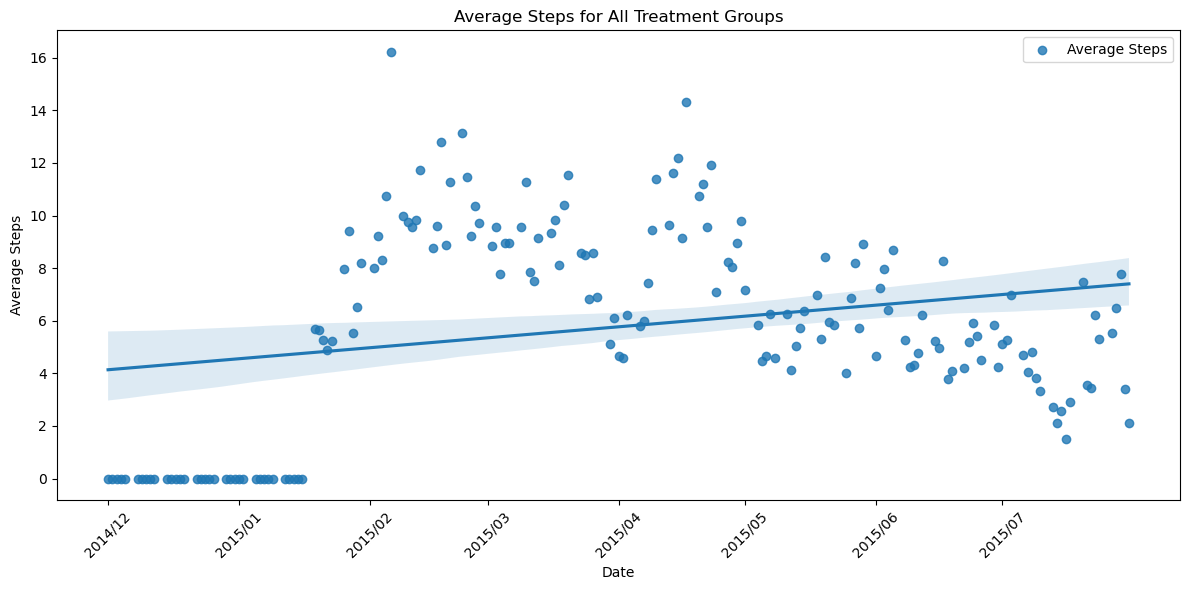

In [160]:
show_average_steps_trend(
    data=average_steps,
    date_column='date',
    value_column='steps',
    title="Average Steps for All Treatment Groups",
    x_label="Date",
    y_label="Average Steps",
    rotate_xticks=45,
    ci=95,
    show_legend=True
)

### Plot 6: Individual plots with average steps superposed

In [161]:
def show_treatment_with_reference(individual_data, average_data, treatment_id,
                                fig_size=(12, 6), title_prefix="Individual Mean Steps and Average",
                                x_label="Date", y_label="Average Steps", rotate_xticks=45):
    """
    Plot individual treatment data with average reference line.

    Parameters:
    -----------
    individual_data : pd.DataFrame
        DataFrame containing individual treatment data
    average_data : pd.DataFrame
        DataFrame containing average steps data
    treatment_id : str/int
        Treatment ID to plot
    fig_size : tuple
        Figure size (width, height)
    title_prefix : str
        Prefix for plot title
    x_label : str
        Label for x-axis
    y_label : str
        Label for y-axis
    rotate_xticks : int
        Rotation angle for x-axis tick labels
    """
    print(f"Plotting data for treatment {treatment_id}")

    # Filter and prepare data
    subset = individual_data[individual_data['treatment_id'] == treatment_id].copy()
    subset['date_numeric'] = (subset['date'] - subset['date'].min()).dt.days
    average_data = average_data.copy()
    average_data['date_numeric'] = (average_data['date'] - subset['date'].min()).dt.days

    # Prepare x-ticks
    months = pd.date_range(start=subset['date'].min(), end=subset['date'].max(), freq='MS')
    month_numeric = (months - subset['date'].min()).days

    # Create figure
    fig, ax = plt.subplots(figsize=fig_size)

    # Plot treatment data (with scatter points)
    sns.regplot(
        data=subset,
        x='date_numeric',
        y='steps',
        scatter=True,
        ci=None,
        label=f'Treatment {treatment_id}',
        ax=ax
    )

    # Plot average reference line (dashed, no scatter)
    sns.regplot(
        data=average_data,
        x='date_numeric',
        y='steps',
        scatter=False,
        ci=95,
        label='Average Steps',
        line_kws={'color': 'black', 'linestyle': '--'},
        ax=ax
    )

    # Set x-ticks and labels
    ax.set_xticks(month_numeric)
    ax.set_xticklabels(months.strftime('%Y/%m'), rotation=rotate_xticks)

    # Set title and labels
    ax.set_title(f"{title_prefix} for Treatment {treatment_id}")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Show legend
    ax.legend()

    plt.tight_layout()
    plt.show()

Plotting data for treatment 1119


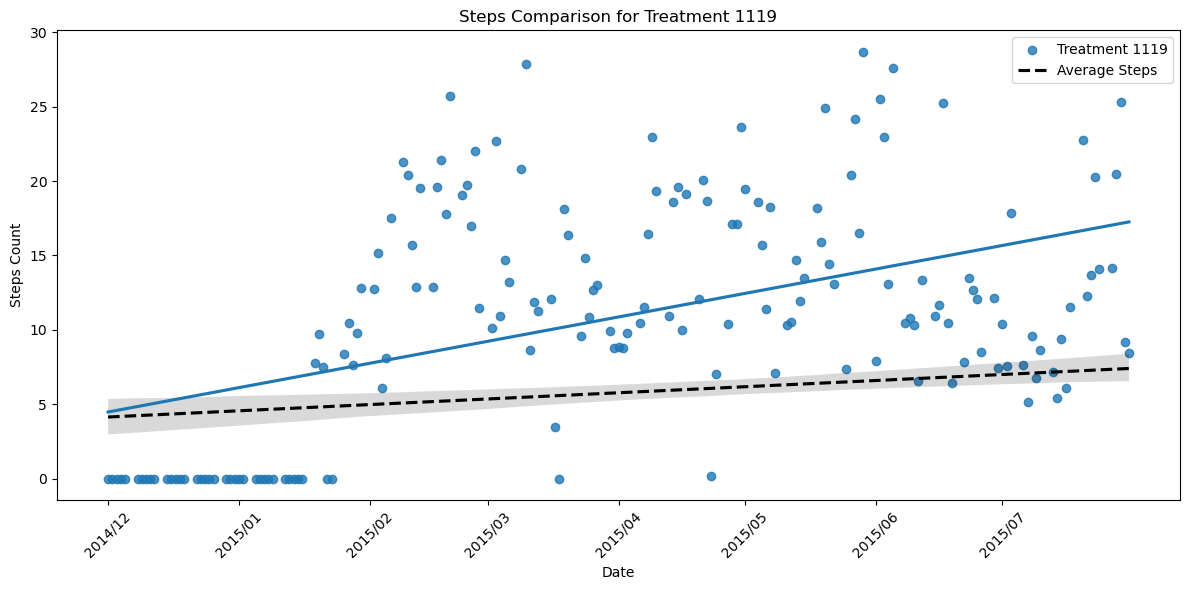

Plotting data for treatment 1120


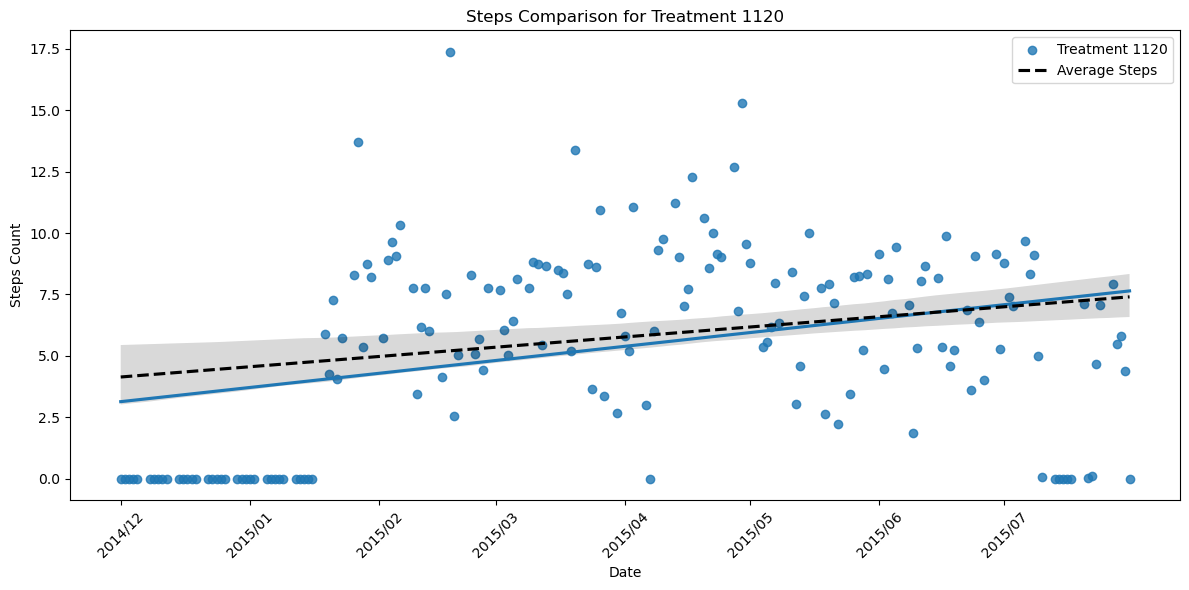

Plotting data for treatment 1121


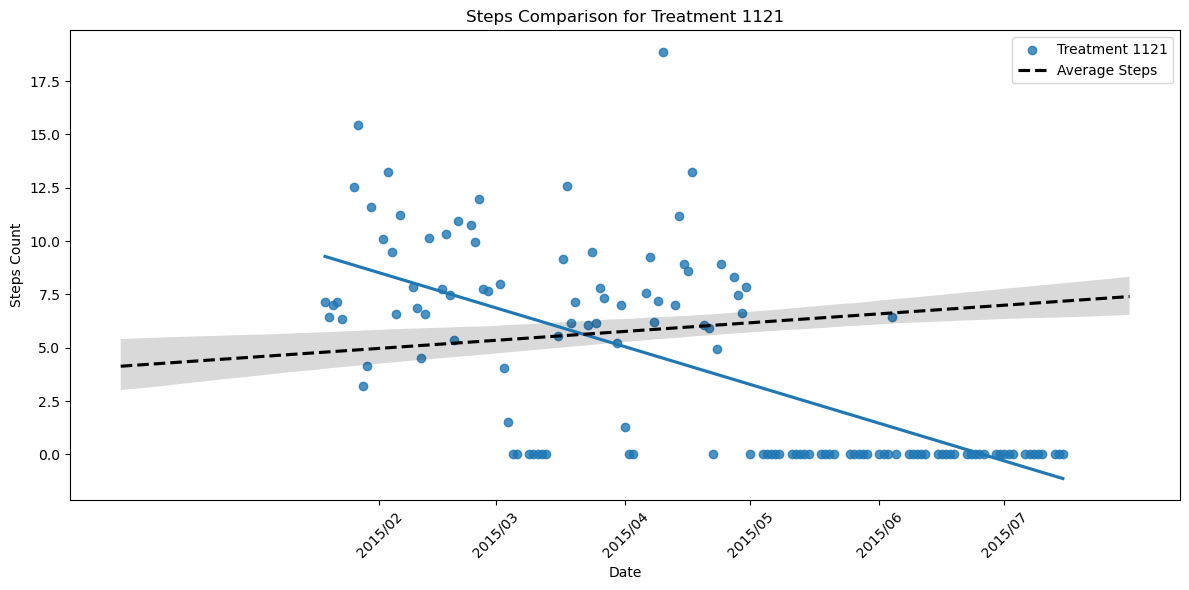

Plotting data for treatment 1122


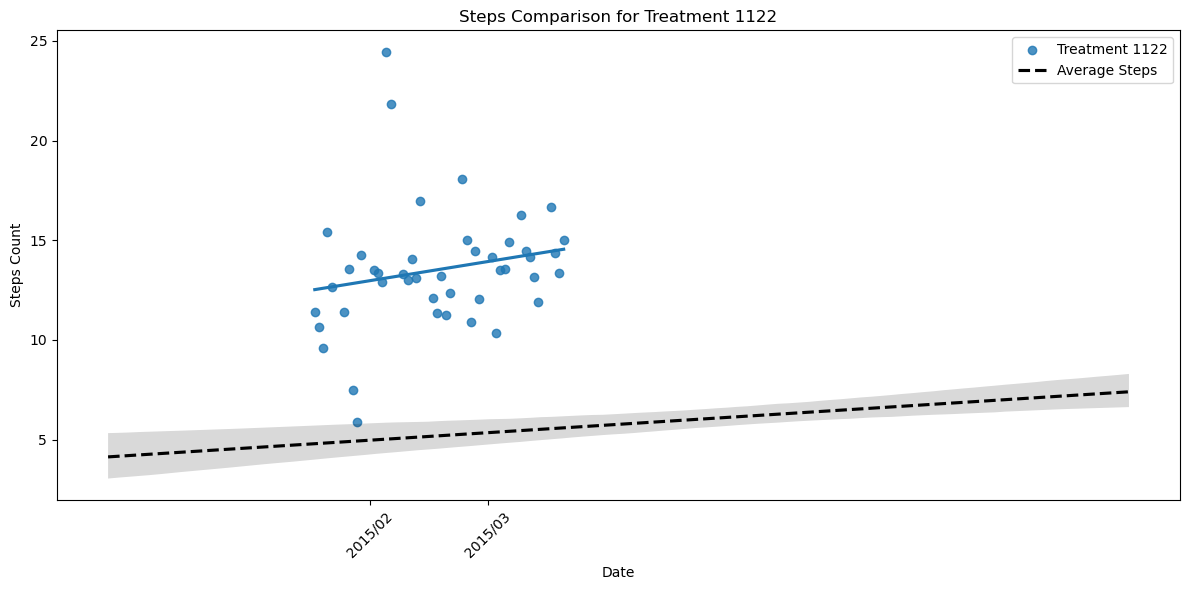

Plotting data for treatment 1123


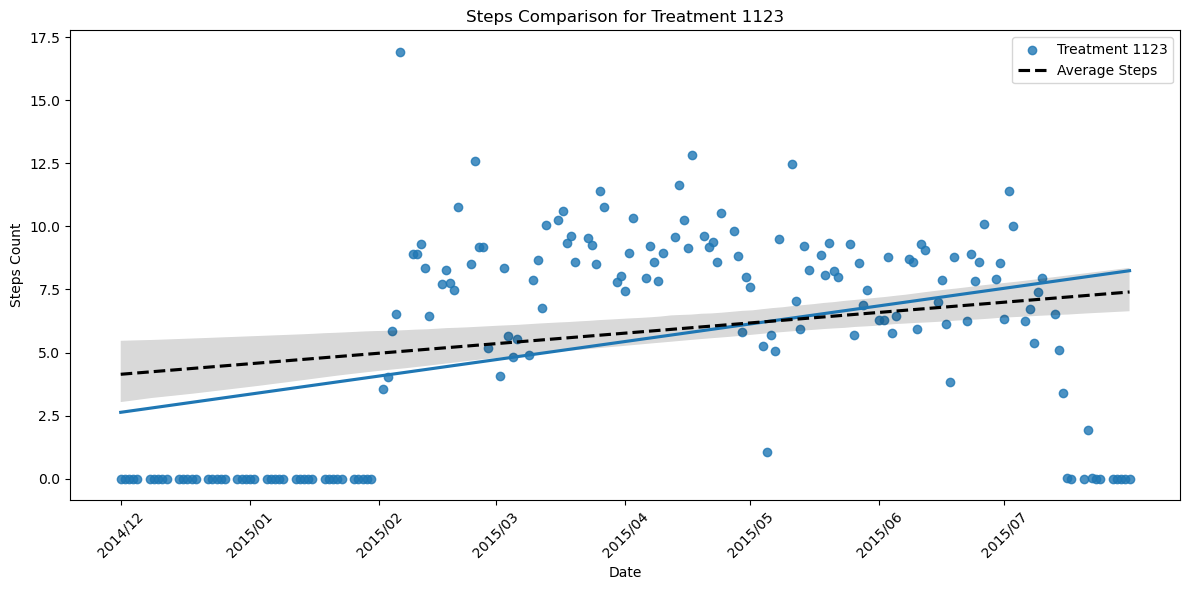

Plotting data for treatment 1124


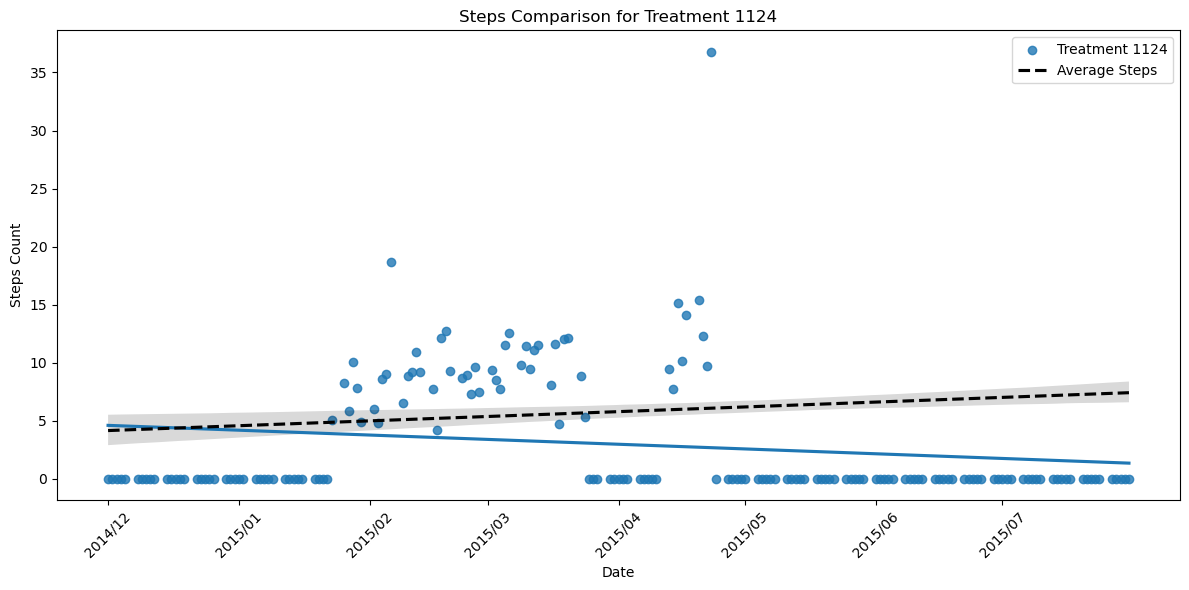

Plotting data for treatment 1125


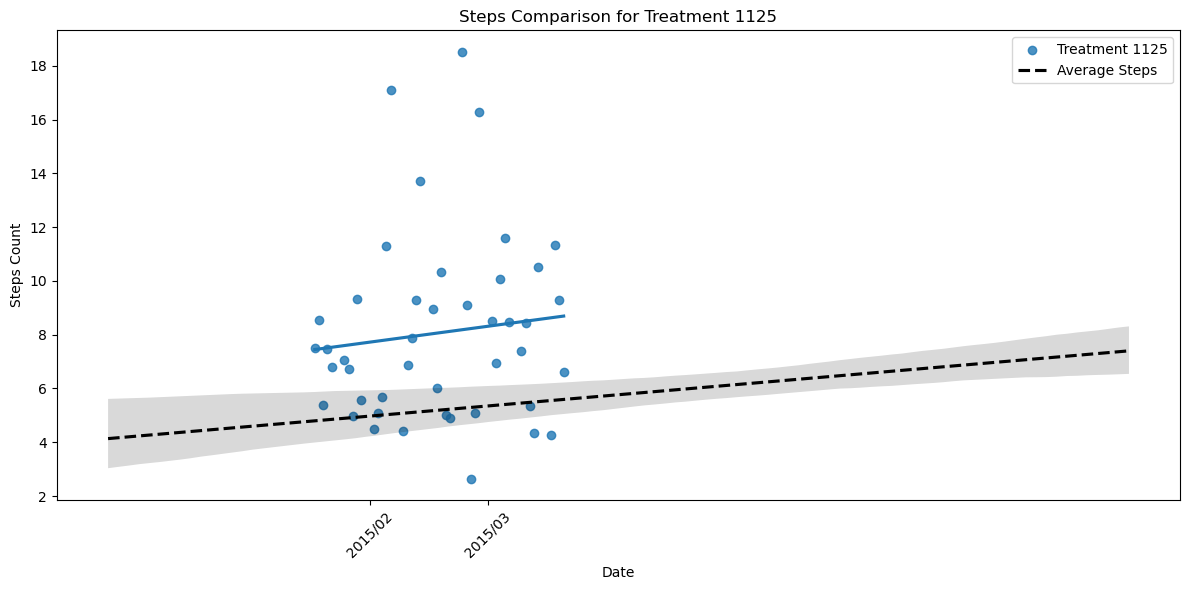

In [162]:
for treatment in treatment_ids:
    show_treatment_with_reference(
        individual_data=individual_means,
        average_data=average_steps,
        treatment_id=treatment,
        title_prefix="Steps Comparison",
        x_label="Date",
        y_label="Steps Count",
        rotate_xticks=45
    )

### Plot 7: Superposed individuals and average steps

In [163]:
# Define a list of colors manually (you peux ajouter plus si nécessaire)
treatment_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [164]:
# Make sure there are enough colors for the number of treatment IDs
if len(treatment_ids) > len(treatment_colors):
    raise ValueError("Not enough colors for the number of treatment IDs!")

In [165]:
def plot_treatments_with_average(individual_data, average_data, treatment_ids,
                                    treatment_colors=None, fig_size=(12, 6),
                                    title="Treatment Steps Comparison",
                                    x_label="Date", y_label="Average Steps",
                                    rotate_xticks=45):
    """
    Plot multiple treatments with scatter points, regression lines, and average reference.

    Parameters:
    -----------
    individual_data : pd.DataFrame
        DataFrame containing individual treatment data
    average_data : pd.DataFrame
        DataFrame containing average steps data
    treatment_ids : list
        List of treatment IDs to plot
    treatment_colors : list
        List of colors for each treatment (default uses seaborn palette)
    fig_size : tuple
        Figure size (width, height)
    title : str
        Plot title
    x_label : str
        Label for x-axis
    y_label : str
        Label for y-axis
    rotate_xticks : int
        Rotation angle for x-axis tick labels
    """
    # Set default colors if not provided
    if treatment_colors is None or len(treatment_colors) < len(treatment_ids):
        treatment_colors = sns.color_palette(n_colors=len(treatment_ids))

    # Prepare common elements
    min_date = average_data['date'].min()
    months = pd.date_range(start=min_date,
                            end=average_data['date'].max(),
                            freq='MS')
    month_numeric = (months - min_date).days

    # Create figure
    fig, ax = plt.subplots(figsize=fig_size)

    # Plot each treatment
    for i, treatment in enumerate(treatment_ids):
        subset = individual_data[individual_data['treatment_id'] == treatment].copy()
        subset['date_numeric'] = (subset['date'] - min_date).dt.days

        # Plot scatter points
        sns.regplot(
            x=subset['date_numeric'],
            y=subset['steps'],
            scatter=True,
            ci=None,
            label=f'Treatment {treatment}',
            color=treatment_colors[i],
            scatter_kws={'alpha': 0.6},
            ax=ax
        )

        # Plot regression line
        sns.regplot(
            x=subset['date_numeric'],
            y=subset['steps'],
            scatter=False,
            ci=None,
            color=treatment_colors[i],
            line_kws={'alpha': 0.8},
            ax=ax
        )

    # Plot average reference line
    avg_data = average_data.copy()
    avg_data['date_numeric'] = (avg_data['date'] - min_date).dt.days
    sns.regplot(
        x=avg_data['date_numeric'],
        y=avg_data['steps'],
        scatter=False,
        ci=95,
        label='Average Steps',
        color='black',
        line_kws={'linestyle': '--', 'alpha': 0.8},
        ax=ax
    )

    # Configure plot appearance
    ax.set_xticks(month_numeric)
    ax.set_xticklabels(months.strftime('%Y/%m'), rotation=rotate_xticks)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()

    plt.tight_layout()
    plt.show()

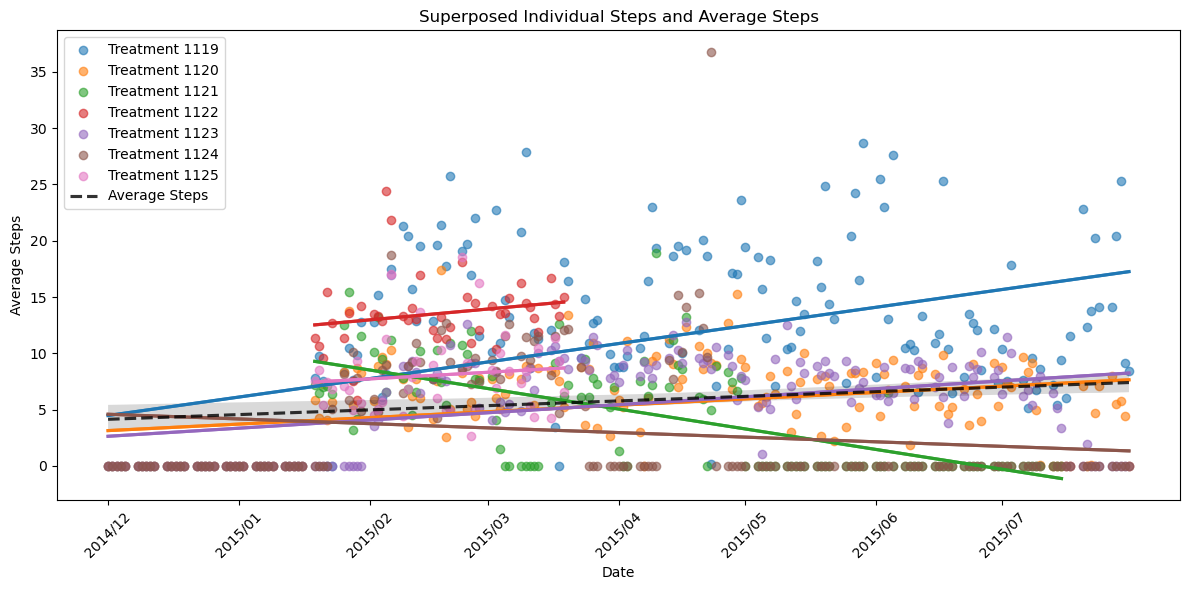

In [166]:
treatment_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Add more if needed
plot_treatments_with_average(
    individual_data=individual_means,
    average_data=average_steps,
    treatment_ids=treatment_ids,
    treatment_colors=treatment_colors,
    title="Superposed Individual Steps and Average Steps",
    x_label="Date",
    y_label="Average Steps",
    rotate_xticks=45
)

### Plot 8: Hourly Activity Patterns

In [167]:
print("\nPLOT 8: Hourly Activity Patterns")


PLOT 8: Hourly Activity Patterns


In [168]:
def plot_hourly_patterns(df, value_column='steps', fig_size=(14, 6),
                        title='Average Steps by Hour of Day',
                        x_label='Hour of Day', y_label='Average Steps',
                        legend_title='Treatment ID', grid=True):
    """
    Plot hourly activity patterns with treatment group comparison.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing datetime and activity data with treatment IDs
    value_column : str, optional
        Column name containing values to plot,
        defaults to 'steps'
    fig_size : tuple, optional
        Figure dimensions (width, height) in inches, defaults to (14, 6)
    title : str, optional
        Title for the plot, defaults to 'Average Steps by Hour of Day'
    x_label : str, optional
        Label for x-axis, defaults to 'Hour of Day'
    y_label : str, optional
        Label for y-axis, defaults to 'Average Steps'
    legend_title : str, optional
        Title for the legend, defaults to 'Treatment ID'
    grid : bool, optional
        Whether to display grid lines, defaults to True

    Returns:
    --------
    None
        Displays the matplotlib plot
    """

    # Extract hour and calculate averages (same as original)
    df = df.copy()
    df['hour'] = df['date'].dt.hour
    hourly_activity = df.groupby(['treatment_id', 'hour']).agg({
        'steps': 'mean'
    }).reset_index()

    # Create plot
    plt.figure(figsize=fig_size)
    ax = sns.lineplot(
        data=hourly_activity,
        x='hour',
        y=value_column,
        hue='treatment_id',
        # Updated parameter to avoid FutureWarning:
        errorbar=None,          # Replaces ci=None

        palette='deep',        # Matches original color scheme
        linewidth=2.5,         # Matches original line thickness
        marker=None,           # No markers (original didn't have them)
        estimator=None         # Show actual values (no aggregation)
    )

    # Exact axis formatting from original
    ax.set_title(title, pad=20, fontsize=14)
    ax.set_xlabel(x_label, labelpad=10)
    ax.set_ylabel(y_label, labelpad=10)
    ax.set_xticks(range(0, 18))
    ax.set_xticklabels(range(0, 18))

    # Grid styling identical to original
    if grid:
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

    # Legend styling identical to original
    legend = ax.legend(
        title=legend_title,
        frameon=True,
        framealpha=1,
        edgecolor='black',
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )
    legend.get_title().set_fontsize(12)

    plt.tight_layout()
    plt.show()

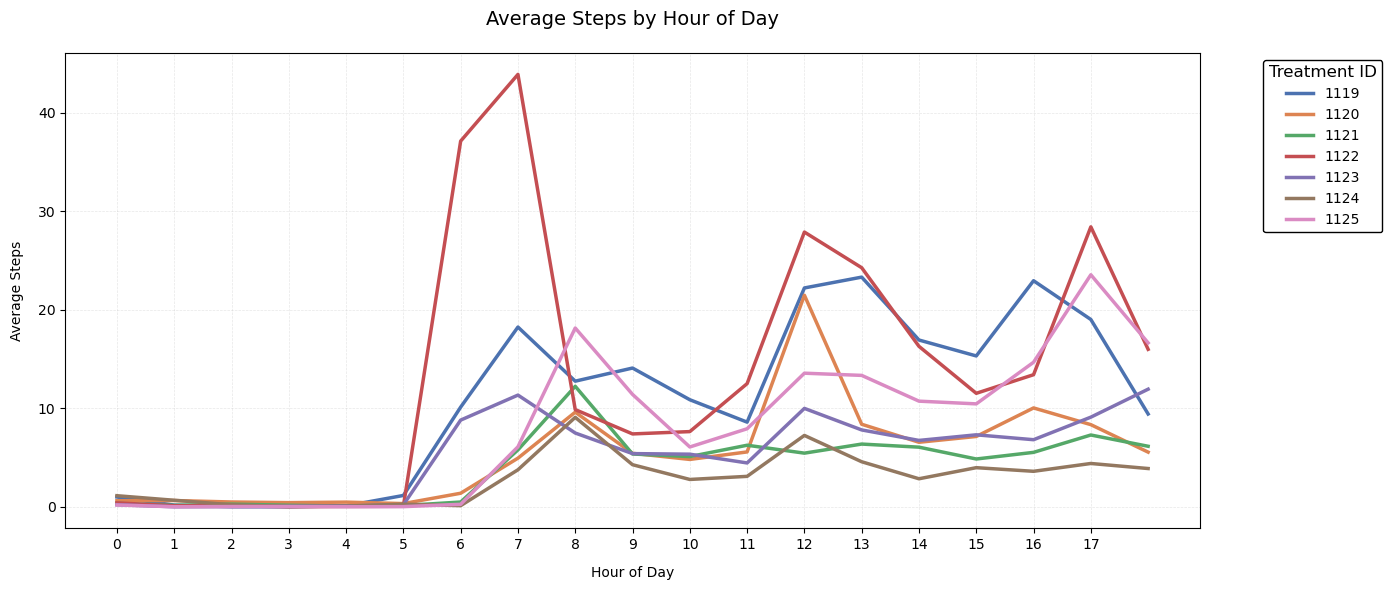

In [169]:
plot_hourly_patterns(df)

### Plot 9: Weekly Activity Patterns

In [170]:
print("\nPLOT 9: Weekly Activity Patterns")


PLOT 9: Weekly Activity Patterns


In [171]:
def plot_weekly_patterns(df):
    df['weekday'] = df['date'].dt.day_name()
    df['hour'] = df['date'].dt.hour

    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    df['weekday'] = pd.Categorical(df['weekday'], categories=weekdays, ordered=True)

    plot_config = [{
        'x': 'hour',
        'y': 'steps',
        'hue': 'treatment_id',
        'xlabel': 'Hour of Day',
        'ylabel': 'Average Steps'
    }]

    n_cols = min(3, df['weekday'].nunique())
    n_rows = int(np.ceil(df['weekday'].nunique() / 3))
    fig_width = n_cols * 4 * 1.2
    fig_height = n_rows * 4
    fig_size = (fig_width, fig_height)

    # Create FacetGrid with original parameters
    g = sns.FacetGrid(df, col='weekday', col_wrap=3,
                        height=4, aspect=1.2)

    for config in plot_config:
        g.map_dataframe(
            sns.lineplot,
            x=config['x'],
            y=config['y'],
            hue=config.get('hue'),
            style=config.get('style'),
            palette=config.get('palette'),
            estimator='mean',
            errorbar=None
        )

    g.add_legend()
    g.set_axis_labels(plot_config[0].get('xlabel', ''),
                    plot_config[0].get('ylabel', ''))
    g.set_titles('{col_name}')

    plt.suptitle('Average Hourly Steps by Weekday', y=1.02)

    plt.show()

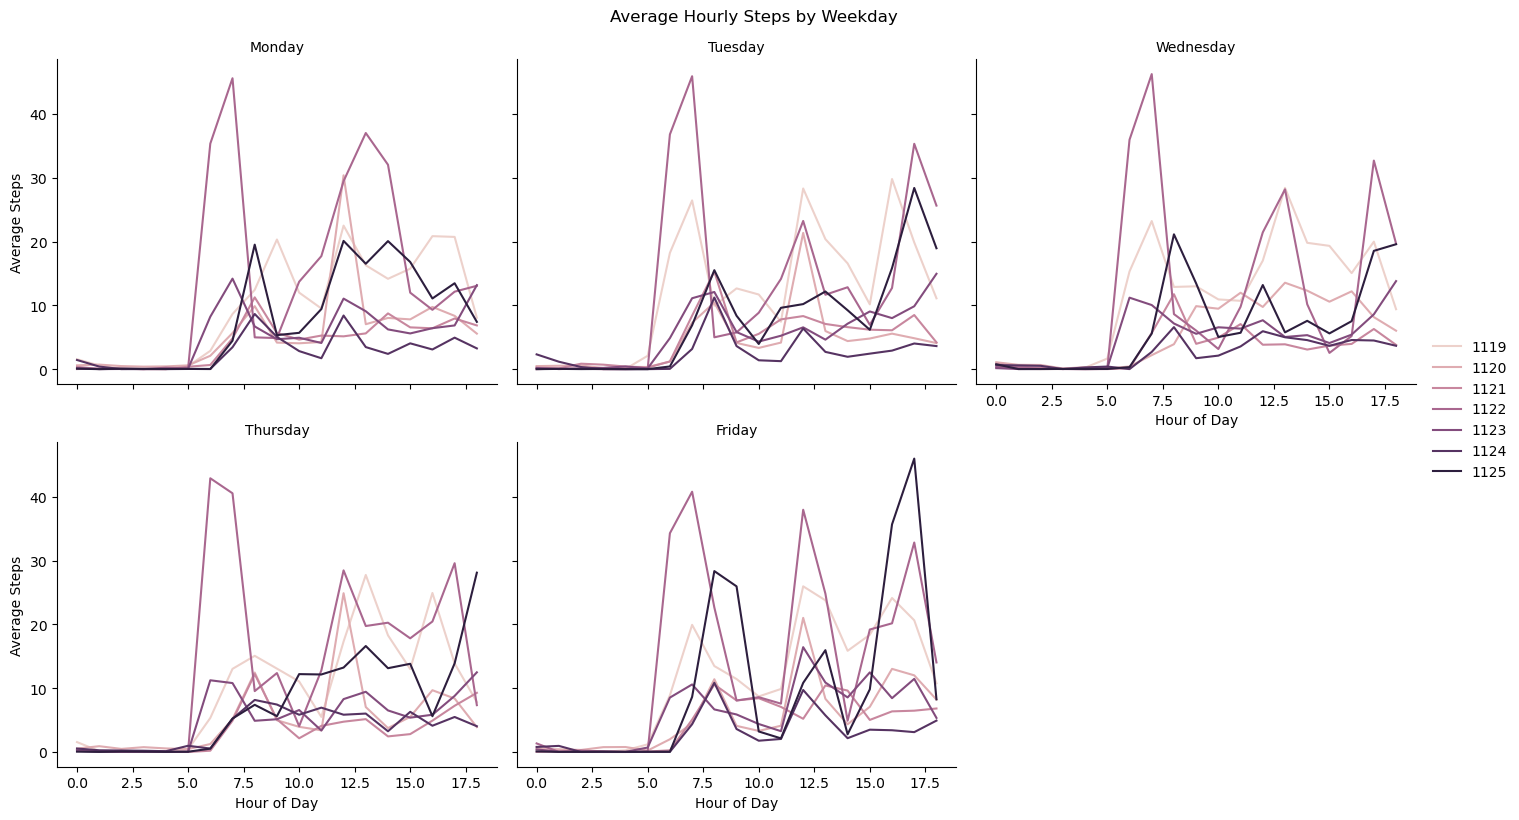

In [172]:
plot_weekly_patterns(df)

### Plot 10: Correlation Analysis

In [173]:
print("\nPLOT 10: Correlation Analysis")
df_numeric = df.select_dtypes(include=['number'])
corr = df_numeric.corr()
corr = corr.dropna(axis=1, how='all').dropna(axis=0, how='all')


PLOT 10: Correlation Analysis


In [174]:
threshold = 0.1
mask = (corr.abs() < threshold).sum(axis=0) == (corr.shape[0] - 1)
low_correlation_cols = corr.columns[mask]
corr = corr.drop(columns=low_correlation_cols, index=low_correlation_cols)

In [175]:
print("Correlation Matrix:")
print(corr)

Correlation Matrix:
              treatment_id     fitbit_id  calories      mets     level  \
treatment_id  1.000000e+00  4.945362e-01 -0.080300 -0.073930 -0.056890   
fitbit_id     4.945362e-01  1.000000e+00 -0.114261 -0.074379 -0.069105   
calories     -8.030042e-02 -1.142606e-01  1.000000  0.979681  0.932637   
mets         -7.392993e-02 -7.437892e-02  0.979681  1.000000  0.956270   
level        -5.688984e-02 -6.910522e-02  0.932637  0.956270  1.000000   
steps        -7.646324e-02 -6.159998e-02  0.951678  0.964365  0.906122   
distance     -6.866567e-02 -6.134644e-02  0.953724  0.963528  0.903404   
hour          4.707637e-14  2.762873e-14  0.196777  0.205912  0.201932   

                 steps  distance          hour  
treatment_id -0.076463 -0.068666  4.707637e-14  
fitbit_id    -0.061600 -0.061346  2.762873e-14  
calories      0.951678  0.953724  1.967773e-01  
mets          0.964365  0.963528  2.059120e-01  
level         0.906122  0.903404  2.019316e-01  
steps         1.000

In [176]:
def plot_correlation_matrix(corr, fig_size=(10, 8), title="Correlation Matrix",
                            x_label="Features", y_label="Features",
                            cmap='coolwarm', center=0, annot=True,
                            font_size=20, fmt=".2f"):
    """
    Plot a correlation matrix heatmap with customizable styling.

    Parameters:
    -----------
    corr : pd.DataFrame
        Correlation matrix to visualize
    fig_size : tuple, optional
        Figure dimensions (width, height), defaults to (10, 8)
    title : str, optional
        Title for the plot, defaults to "Correlation Matrix"
    x_label : str, optional
        Label for x-axis, defaults to "Features"
    y_label : str, optional
        Label for y-axis, defaults to "Features"
    cmap : str, optional
        Colormap for the heatmap, defaults to 'coolwarm'
    center : float, optional
        Value at which to center the colormap, defaults to 0
    annot : bool, optional
        Whether to show correlation values in cells, defaults to True
    font_size : int, optional
        Font size for annotations and labels, defaults to 20
    fmt : str, optional
        String formatting for annotations, defaults to ".2f"

    Returns:
    --------
    None
        Displays the matplotlib plot

    Examples:
    ---------
    >>> plot_correlation_matrix(df.corr())
    >>> plot_correlation_matrix(df.corr(), cmap='viridis', font_size=16)
    """
    plt.figure(figsize=fig_size)
    ax = sns.heatmap(
        corr,
        annot=annot,
        cmap=cmap,
        center=center,
        fmt=fmt
    )

    ax.set_title(title, fontsize=font_size, pad=20)
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)

    # Adjust tick label sizes
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=font_size*0.5)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=font_size*0.5)

    plt.tight_layout()
    plt.show()

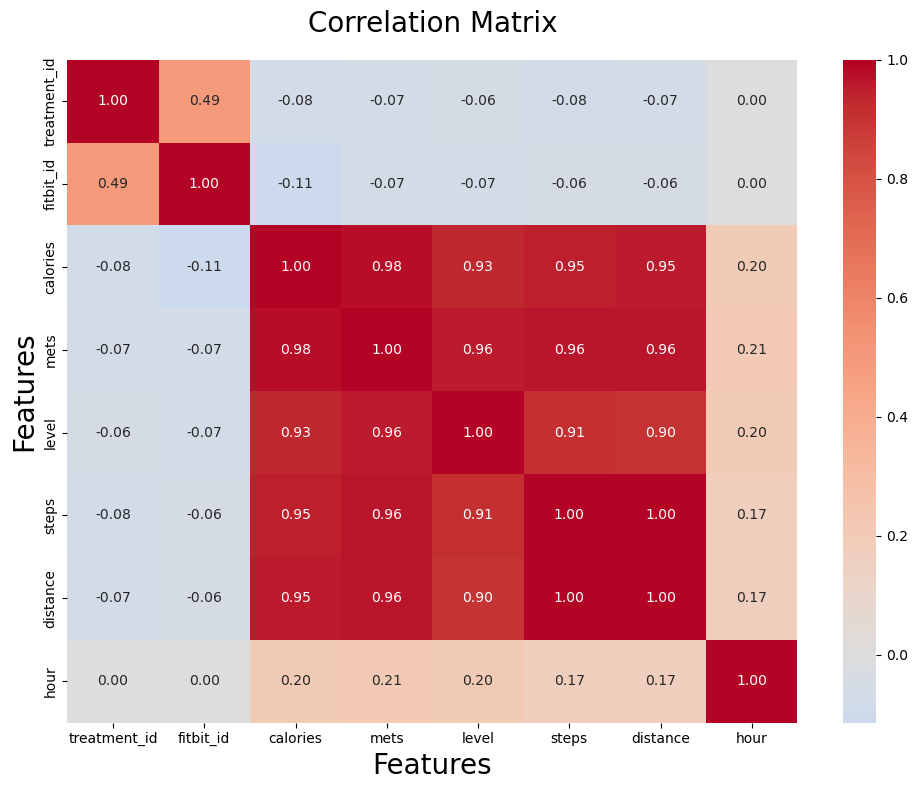

In [177]:
# Basic usage
plot_correlation_matrix(corr)

### Plot 11: Feature Relationships DAG

In [178]:
print("\nPLOT 11: Feature Relationships DAG")
dag = nx.DiGraph()
dag_features = ['date', 'working_days', 'calories', 'mets', 'level', 'steps', 'distance', 'season']
dag.add_nodes_from(dag_features)


PLOT 11: Feature Relationships DAG


In [179]:
edges = [
    ('date', 'working_days'),
    ('date', 'season'),
    ('working_days', 'steps'),
    ('season', 'steps'),
    ('steps', 'calories'),
    ('steps', 'mets'),
    ('steps', 'level'),
    ('steps', 'distance'),
]

dag.add_edges_from(edges)

In [180]:
pos = {
    'date': (0, 1),
    'working_days': (-1, 0),
    'calories': (-1, -1),
    'mets': (0, -1),
    'season': (1, 0),
    'steps': (0, 0),
    'distance': (-1, -2),
    'level': (1, -2)
}

In [181]:
def plot_dag(dag, pos, fig_size=(10, 8), title="DAG Representing Feature Relationships",
                node_size=2000, node_color="skyblue", node_font_size=10,
                font_weight='bold', edge_color='black', title_font_size=20):
    """
    Plot a Directed Acyclic Graph (DAG) with customizable styling.

    Parameters:
    -----------
    dag : networkx.DiGraph
        The directed acyclic graph to visualize
    pos : dict
        Dictionary of node positions (layout)
    fig_size : tuple, optional
        Figure dimensions (width, height), defaults to (10, 8)
    title : str, optional
        Title for the plot, defaults to "DAG Representing Feature Relationships"
    node_size : int, optional
        Size of nodes in the graph, defaults to 2000
    node_color : str, optional
        Color of nodes, defaults to "skyblue"
    node_font_size : int, optional
        Font size for node labels, defaults to 10
    font_weight : str, optional
        Font weight for node labels ('normal', 'bold', etc.), defaults to 'bold'
    edge_color : str, optional
        Color of edges, defaults to 'black'
    title_font_size : int, optional
        Font size for title, defaults to 20

    Returns:
    --------
    None
        Displays the matplotlib plot
    """
    plt.figure(figsize=fig_size)
    ax = plt.gca()

    nx.draw_networkx(
        dag,
        pos=pos,
        with_labels=True,
        node_size=node_size,
        node_color=node_color,
        font_size=node_font_size,
        font_weight=font_weight,
        edge_color=edge_color,
        ax=ax
    )

    ax.set_title(title, fontsize=title_font_size, pad=20)
    ax.axis('off')  # Turn off axis
    plt.tight_layout()
    plt.show()

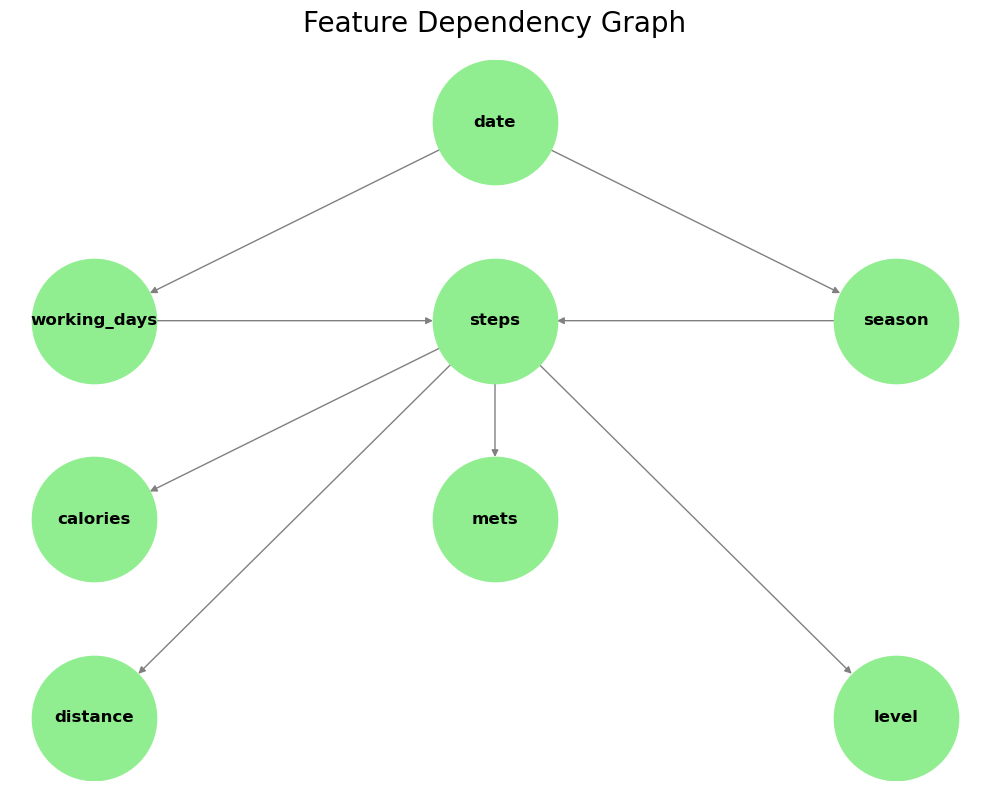

In [182]:
# Customized version
plot_dag(
    dag=dag,
    pos=pos,
    title="Feature Dependency Graph",
    node_color="lightgreen",
    node_size=8000,
    edge_color="gray",
    node_font_size=12
)

In [183]:
print("Exploratory data analysis complete!\n")

Exploratory data analysis complete!



## Step 4: Feature Engineering

In [184]:
print("STEP 4: Feature engineering...")

STEP 4: Feature engineering...


In [185]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [186]:
print("Adding temporal features...")
df['season'] = df['date'].apply(get_season)
df['hour'] = df['date'].dt.hour
df['is_weekend'] = df['date'].dt.weekday >= 5
df['cumulative_steps'] = df.groupby(['treatment_id', df['date'].dt.date])['steps'].cumsum()
df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month

Adding temporal features...


In [187]:
print("Creating target variable...")
df['target'] = 0
for user_id, user_avg in df[df['date'].dt.hour <= 18].groupby('treatment_id')['cumulative_steps'].mean().items():
    mask = (df['treatment_id'] == user_id) & (df['date'].dt.hour <= 18)
    df.loc[mask, 'target'] = (df.loc[mask, 'cumulative_steps'] >= user_avg).astype(int)

Creating target variable...


In [188]:
print("Creating one-hot encoded features...")
for season in ['Spring', 'Summer', 'Autumn', 'Winter']:
    df[f'season_{season}'] = (df['season'] == season).astype(int)

Creating one-hot encoded features...


In [189]:
print("Adding derived features...")
df['steps_per_hour'] = df['cumulative_steps'] / (df['hour'] + 1)
df['steps_remaining'] = (overall_avg_steps * 60 * 24) - df['cumulative_steps']
df['hours_remaining'] = 18 - df['hour']
df['required_pace'] = df['steps_remaining'] / (df['hours_remaining'] + 0.1)

Adding derived features...


In [190]:
features = [
    'hour', 'is_weekend', 'cumulative_steps', 'steps_per_hour',
    'steps_remaining', 'hours_remaining', 'required_pace',
    'season_Spring', 'season_Summer', 'season_Autumn', 'season_Winter',
    'month'
]

In [191]:
print("Final feature set:")
print(features)

Final feature set:
['hour', 'is_weekend', 'cumulative_steps', 'steps_per_hour', 'steps_remaining', 'hours_remaining', 'required_pace', 'season_Spring', 'season_Summer', 'season_Autumn', 'season_Winter', 'month']


In [192]:
print("Cleaning data...")
df_clean = df.dropna(subset=features).copy()
print(f"Clean dataset shape: {df_clean.shape}")

Cleaning data...
Clean dataset shape: (1043100, 25)


In [193]:
print("Feature engineering complete!\n")

Feature engineering complete!



## Step 5: Model Training

In [194]:
print("STEP 5: Model training and evaluation...")

STEP 5: Model training and evaluation...


In [195]:
label_map = {0: "Not Reached", 1: "Reached"}  # Assuming 1 = Success/Event Occurred

In [196]:
print("Splitting data into train and test sets...")
train_users, test_users = train_test_split(df_clean['treatment_id'].unique(), test_size=0.3, random_state=42)
train_data = df_clean[df_clean['treatment_id'].isin(train_users)]
test_data = df_clean[df_clean['treatment_id'].isin(test_users)]

Splitting data into train and test sets...


In [197]:
print("\nUser IDs for training:", train_users)
print("User IDs for testing:", test_users)


User IDs for training: [1121 1123 1122 1125]
User IDs for testing: [1119 1120 1124]


In [198]:
X_train = train_data[features]
y_train = train_data['target']
X_test = test_data[features]
y_test = test_data['target']

In [199]:
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True).rename(label_map))

print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True).rename(label_map))


Class distribution in training set:
target
Not Reached    0.649993
Reached        0.350007
Name: proportion, dtype: float64

Class distribution in test set:
target
Not Reached    0.71801
Reached        0.28199
Name: proportion, dtype: float64


In [200]:
print("\nTraining model with SMOTE...")


Training model with SMOTE...


In [201]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test, label_map=None, apply_smote=True):
    """
    Train and evaluate a Random Forest classifier with optional SMOTE balancing.

    Parameters:
    -----------
    X_train : pd.DataFrame or np.array
        Training features
    y_train : pd.Series or np.array
        Training labels
    X_test : pd.DataFrame or np.array
        Test features
    y_test : pd.Series or np.array
        Test labels
    label_map : dict, optional
        Mapping dictionary for label conversion
    apply_smote : bool, optional
        Whether to apply SMOTE oversampling, defaults to True

    Returns:
    --------
    tuple
        (trained_model, classification_report_dict, y_test_mapped, y_pred_mapped, y_pred)
    """
    default_params = {
        'random_state': 42,
        'class_weight': 'balanced',
        'n_estimators': 200,
        'min_samples_leaf': 5,
        'max_depth': 10
    }

    try:
        if apply_smote:
            smote = SMOTE(random_state=42)
            X_res, y_res = smote.fit_resample(X_train, y_train)
            print("Applied SMOTE for class balancing")
        else:
            X_res, y_res = X_train, y_train
            print("Using original imbalanced data")

        model = RandomForestClassifier(**default_params)
        model.fit(X_res, y_res)
        y_pred = model.predict(X_test)

        # Map labels if provided
        y_test_mapped = y_test.map(label_map) if label_map else y_test
        y_pred_mapped = pd.Series(y_pred).map(label_map) if label_map else y_pred

        report = classification_report(y_test_mapped, y_pred_mapped, output_dict=True)
        report.pop("accuracy", None)

        print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
        print("\nClassification Report:")
        print(classification_report(y_test_mapped, y_pred_mapped))

        return model, report, y_test_mapped, y_pred_mapped, y_pred

    except ValueError as e:
        print(f"\nSMOTE Error: {e}")
        print("Falling back to original imbalanced data")
        model = RandomForestClassifier(**default_params)
        model.fit(X_train, y_train)
        return model, None, None, None

In [202]:
def show_classification_heatmap(report, fig_size=(12, 6), cmap='RdYlGn', title='Classification Report Heatmap'):
    """
    Display classification metrics as a heatmap.

    Parameters:
    -----------
    report : dict
        Classification report dictionary
    fig_size : tuple, optional
        Figure dimensions, defaults to (12, 6)
    cmap : str, optional
        Colormap for heatmap, defaults to 'RdYlGn'
    title : str, optional
        Plot title, defaults to 'Classification Report Heatmap'
    """
    plt.figure(figsize=fig_size)
    sns.heatmap(
        pd.DataFrame(report).iloc[:-1, :].T,
        annot=True,
        cmap=cmap,
        vmin=0,
        vmax=1,
        cbar=True
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [203]:
def show_classification_metrics(report, fig_size=(12, 6),
                                palette={'precision': 'blue', 'recall': 'orange', 'f1-score': 'green'},
                                title='Classification Report Metrics'):
    """
    Display classification metrics as a bar plot.

    Parameters:
    -----------
    report : dict
        Classification report dictionary
    fig_size : tuple, optional
        Figure dimensions, defaults to (12, 6)
    palette : dict, optional
        Color palette for metrics, defaults to blue/orange/green
    title : str, optional
        Plot title, defaults to 'Classification Report Metrics'
    """
    metrics_df = pd.DataFrame(report).transpose().iloc[:-1, :]
    metrics_df = metrics_df.reset_index().melt(
        id_vars='index',
        value_vars=['precision', 'recall', 'f1-score'],
        var_name='Metric',
        value_name='Score'
    )

    plt.figure(figsize=fig_size)
    sns.barplot(
        x='index',
        y='Score',
        hue='Metric',
        data=metrics_df,
        palette=palette
    )
    plt.title(title)
    plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

Applied SMOTE for class balancing
Accuracy: 0.97

Classification Report:
              precision    recall  f1-score   support

 Not Reached       0.99      0.97      0.98    429729
     Reached       0.92      0.97      0.95    168771

    accuracy                           0.97    598500
   macro avg       0.96      0.97      0.96    598500
weighted avg       0.97      0.97      0.97    598500



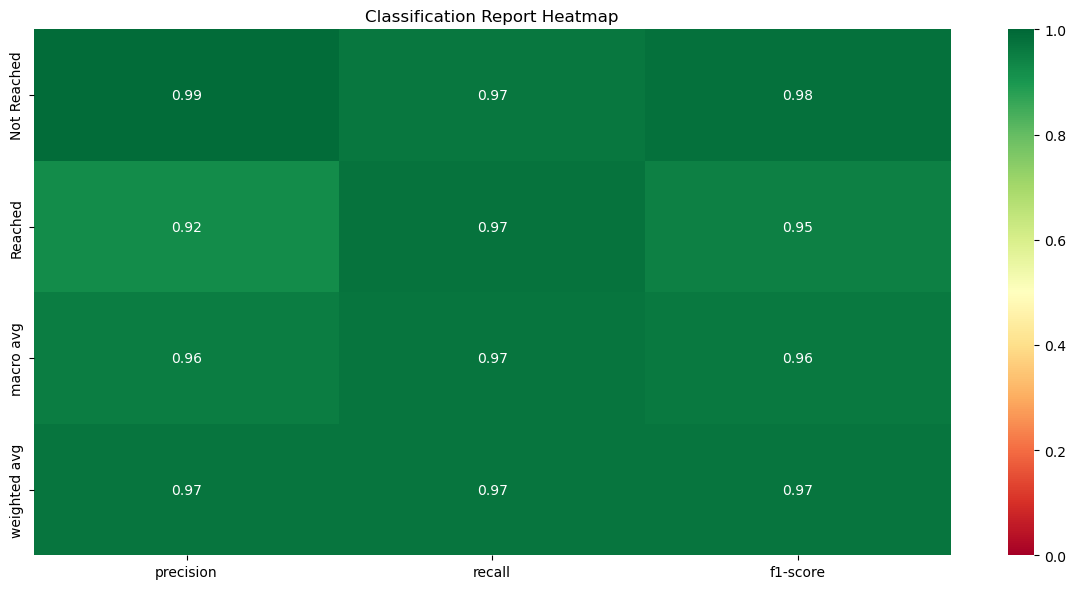

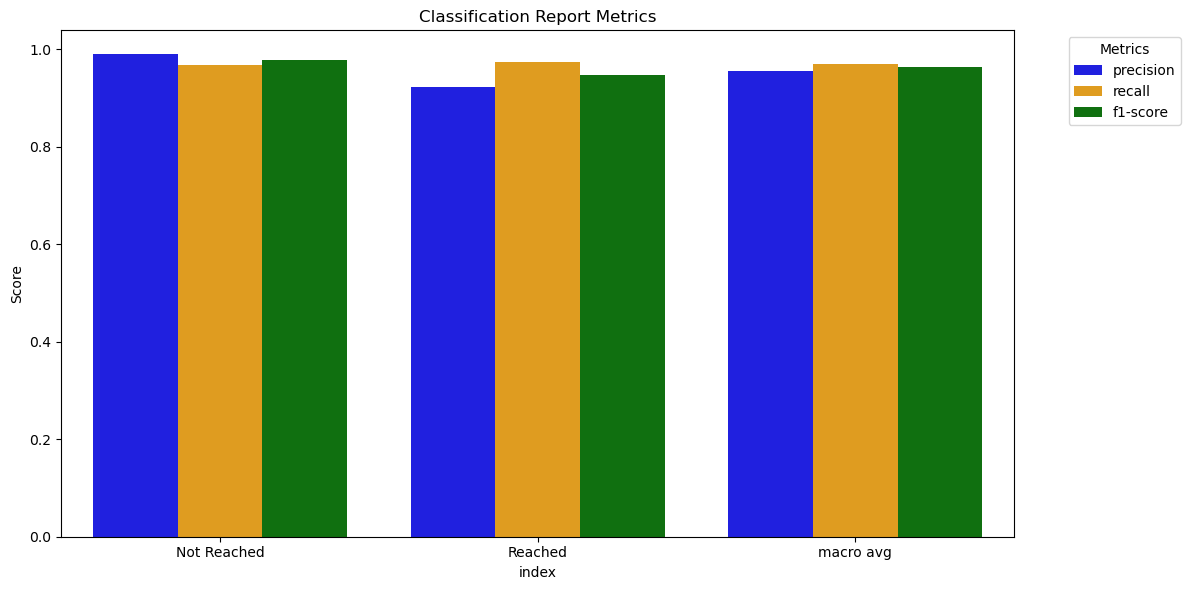

In [204]:
# Train and evaluate model
model, report, y_test_mapped, y_pred_mapped, y_pred = train_and_evaluate_model(
    X_train, y_train, X_test, y_test,
    label_map=label_map,
    apply_smote=True
)

# Show visualizations if report exists
if report:
    show_classification_heatmap(report)
    show_classification_metrics(report)

In [205]:
# Confusion Matrix Analysis (with label_map)
cm = confusion_matrix(y_test, y_pred)  # Original numeric values for calculations

print("\n" + "="*50)
print("DETAILED CONFUSION MATRIX ANALYSIS")
print("="*50)
print(f"True Negatives (Correct {label_map[0]}): {cm[0,0]}")
print(f"False Positives ({label_map[0]} predicted as {label_map[1]}): {cm[0,1]}")
print(f"False Negatives ({label_map[1]} predicted as {label_map[0]}): {cm[1,0]}")
print(f"True Positives (Correct {label_map[1]}): {cm[1,1]}")
print("\nSummary:")
print(f"Total errors: {cm[0,1] + cm[1,0]} ({(cm[0,1] + cm[1,0])/cm.sum()*100:.2f}% of cases)")
print("="*50 + "\n")


DETAILED CONFUSION MATRIX ANALYSIS
True Negatives (Correct Not Reached): 415957
False Positives (Not Reached predicted as Reached): 13772
False Negatives (Reached predicted as Not Reached): 4513
True Positives (Correct Reached): 164258

Summary:
Total errors: 18285 (3.06% of cases)



In [206]:
print("\n" + "="*50)
print("COMPLETE CLASSIFICATION REPORT (Mapped Labels)")
print("="*50)

# Define target names using label_map
target_names = [label_map[0], label_map[1]]  # ["Not Reached", "Reached"]

# Generate and print classification report
report_str = classification_report(
    y_test,
    y_pred,
    target_names=target_names,
    digits=3
)
# Clean and print report (remove accuracy and empty lines)
print('\n'.join([
    line for line in report_str.split('\n')
    if 'accuracy' not in line and line.strip()
]))

# Calculate extended metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred, average=None
)

# Print formatted metrics with labels
print("\n" + "-"*40)
print("DETAILED PERFORMANCE METRICS")
print("-"*40)
print(f"{'Metric':<12} | {label_map[0]:<12} | {label_map[1]:<12}")
print("-"*40)
print(f"{'Precision':<12} | {precision[0]:<12.3f} | {precision[1]:<12.3f}")
print(f"{'Recall':<12} | {recall[0]:<12.3f} | {recall[1]:<12.3f}")
print(f"{'F1-Score':<12} | {f1[0]:<12.3f} | {f1[1]:<12.3f}")
print(f"{'Support':<12} | {support[0]:<12,.0f} | {support[1]:<12,.0f}")
print("="*50)


COMPLETE CLASSIFICATION REPORT (Mapped Labels)
              precision    recall  f1-score   support
 Not Reached      0.989     0.968     0.978    429729
     Reached      0.923     0.973     0.947    168771
   macro avg      0.956     0.971     0.963    598500
weighted avg      0.970     0.969     0.970    598500

----------------------------------------
DETAILED PERFORMANCE METRICS
----------------------------------------
Metric       | Not Reached  | Reached     
----------------------------------------
Precision    | 0.989        | 0.923       
Recall       | 0.968        | 0.973       
F1-Score     | 0.978        | 0.947       
Support      | 429,729      | 168,771     


In [207]:
def show_normalized_confusion_matrix(cm, label_map, model_name="Random Forest",
                                    fig_size=(10, 7), cmap='Blues',
                                    font_size=12, title_font_size=14):
    """
    Display a normalized confusion matrix as a percentage heatmap.

    Parameters:
    -----------
    cm : np.array
        Confusion matrix (2x2)
    label_map : dict
        Mapping from class indices to label names (e.g., {0: "Negative", 1: "Positive"})
    model_name : str, optional
        Name of model to include in title, defaults to "Random Forest"
    fig_size : tuple, optional
        Figure dimensions, defaults to (10, 7)
    cmap : str, optional
        Colormap for heatmap, defaults to 'Blues'
    font_size : int, optional
        Font size for annotations, defaults to 12
    title_font_size : int, optional
        Font size for title, defaults to 14

    Returns:
    --------
    None
        Displays the matplotlib plot
    """
    # Calculate normalized matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    annot_labels = np.array([f"{val:.1f}%" for val in cm_normalized.flatten()]).reshape(cm_normalized.shape)

    # Get label names
    labels = [label_map[0], label_map[1]]

    # Create plot
    plt.figure(figsize=fig_size)
    ax = sns.heatmap(
        cm_normalized,
        annot=annot_labels,
        fmt='',
        cmap=cmap,
        xticklabels=labels,
        yticklabels=labels,
        linewidths=0.5,
        linecolor='grey',
        cbar_kws={'label': 'Percentage by Actual Class'},
        annot_kws={'size': font_size}
    )

    # Configure plot appearance
    ax.set_title(f'Normalized Confusion Matrix (%)\nModel: {model_name}',
                fontsize=title_font_size, pad=20)
    ax.set_xlabel('Model Predictions')
    ax.set_ylabel('True Values')

    # Set custom ticks to center labels
    ax.set_xticks([0.5, 1.5])
    ax.set_yticks([0.5, 1.5])
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticklabels(labels, rotation=0)

    plt.tight_layout()
    plt.show()

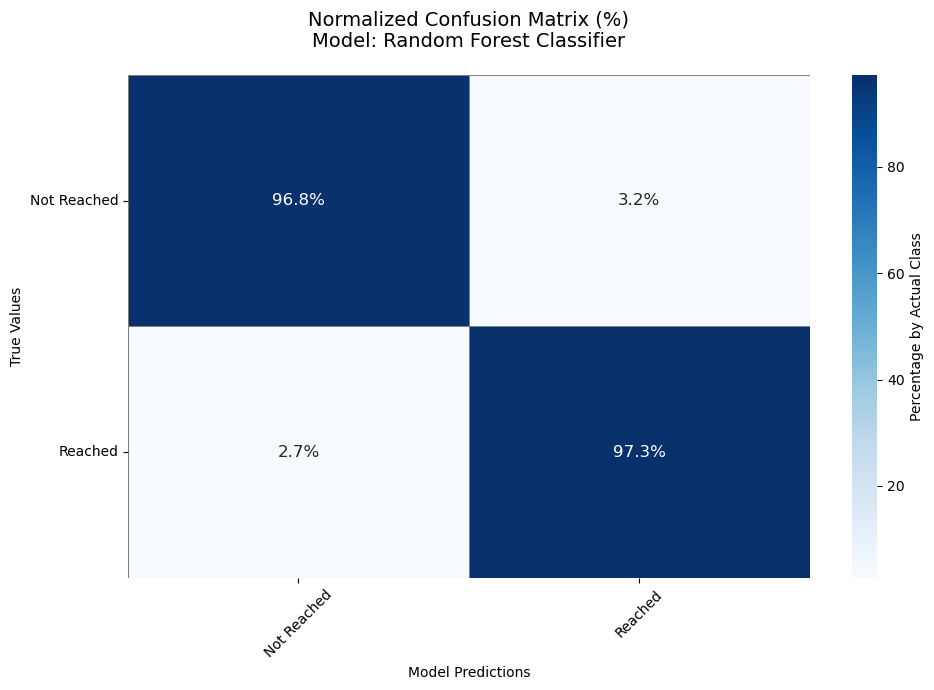

In [208]:
show_normalized_confusion_matrix(
    cm=cm,
    label_map=label_map,
    model_name="Random Forest Classifier",
    cmap='Blues',
    font_size=12,
    title_font_size=14
)

In [209]:
def plot_precision_recall_vs_threshold(y_true, y_probs, figsize=(8, 6)):
    """
    Plot precision and recall curves as a function of the decision threshold.

    Parameters:
    -----------
    y_true : array-like
        True binary labels (0 or 1)
    y_probs : array-like
        Predicted probabilities for the positive class (1)
    figsize : tuple, optional
        Size of the figure (width, height) in inches (default: (8, 6))
    """
    precision_curve, recall_curve, thresholds = precision_recall_curve(y_true, y_probs)

    plt.figure(figsize=figsize)
    plt.plot(thresholds, precision_curve[:-1], label="Precision", linewidth=2, color='blue')
    plt.plot(thresholds, recall_curve[:-1], label="Recall", linewidth=2, color='orange')

    # Enhanced labels and titles
    plt.xlabel("Decision Threshold", fontsize=12, labelpad=10)
    plt.ylabel("Score", fontsize=12, labelpad=10)
    plt.legend(fontsize=11, framealpha=0.9)
    plt.title("Precision-Recall Tradeoff by Threshold", pad=20, fontsize=14, fontweight='bold')

    # Formatting improvements
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xlim([0, 1])  # Explicit threshold range
    plt.ylim([0, 1.05])  # Slight padding for visibility

    plt.tight_layout()
    plt.show()

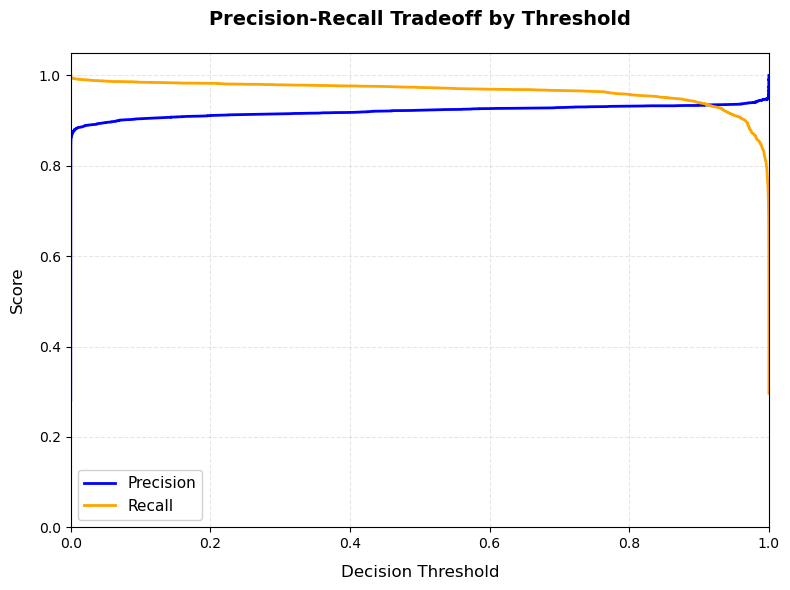

In [210]:
if hasattr(model, "predict_proba"):
    y_probs = model.predict_proba(X_test)[:, 1]
    plot_precision_recall_vs_threshold(y_test, y_probs)

In [211]:
def setup_error_data(y_test, y_pred, X_test):
    """Identify error cases and calculate their characteristics"""
    fp_indices = np.where((y_test == 0) & (y_pred == 1))[0]  # False positives
    fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]  # False negatives

    if hasattr(X_test, 'iloc'):  # If pandas DataFrame
        fp_means = X_test.iloc[fp_indices].mean()
        fn_means = X_test.iloc[fn_indices].mean()
        comparison_df = pd.DataFrame({
            'False Positives': fp_means,
            'False Negatives': fn_means
        }).sort_values(by='False Positives', ascending=False)
        comparison_df['Difference'] = comparison_df['False Positives'] - comparison_df['False Negatives']
    else:
        comparison_df = None

    return {
        'fp_indices': fp_indices,
        'fn_indices': fn_indices,
        'fp_means': fp_means if hasattr(X_test, 'iloc') else None,
        'fn_means': fn_means if hasattr(X_test, 'iloc') else None,
        'comparison_df': comparison_df
    }

In [212]:
error_data = setup_error_data(y_test, y_pred, X_test)

In [213]:
def print_error_summary(fp_indices, fn_indices, y_test):
    """Print basic error statistics"""
    print("\n" + "="*50)
    print("ERROR ANALYSIS")
    print("="*50)
    print(f"False positives (FP): {len(fp_indices)} cases ({len(fp_indices)/len(y_test)*100:.1f}%)")
    print(f"False negatives (FN): {len(fn_indices)} cases ({len(fn_indices)/len(y_test)*100:.1f}%)")

In [214]:
print_error_summary(error_data['fp_indices'], error_data['fn_indices'], y_test)


ERROR ANALYSIS
False positives (FP): 13772 cases (2.3%)
False negatives (FN): 4513 cases (0.8%)


In [215]:
def print_detailed_error_analysis(fp_means, fn_means, fp_indices, fn_indices, y_test):
    """Print detailed error characteristics"""
    print("\n" + "="*50)
    print("DETAILED ERROR ANALYSIS")
    print("="*50)

    print("\nAverage characteristics of False Positives (FP):")
    print(fp_means.to_frame().T.round(2))
    print(f"\nCount: {len(fp_indices)} cases ({len(fp_indices)/len(y_test)*100:.1f}% of total)")

    print("\nAverage characteristics of False Negatives (FN):")
    print(fn_means.to_frame().T.round(2))
    print(f"\nCount: {len(fn_indices)} cases ({len(fn_indices)/len(y_test)*100:.1f}% of total)")

In [216]:
print_detailed_error_analysis(error_data['fp_means'], error_data['fn_means'],
                                error_data['fp_indices'], error_data['fn_indices'], y_test)


DETAILED ERROR ANALYSIS

Average characteristics of False Positives (FP):
    hour  is_weekend  cumulative_steps  steps_per_hour  steps_remaining  \
0  10.54         0.0            2916.8          264.31          5389.79   

   hours_remaining  required_pace  season_Spring  season_Summer  \
0             7.46        1035.16           0.46           0.44   

   season_Autumn  season_Winter  month  
0            0.0           0.11   4.73  

Count: 13772 cases (2.3% of total)

Average characteristics of False Negatives (FN):
   hour  is_weekend  cumulative_steps  steps_per_hour  steps_remaining  \
0   9.0         0.0           2295.19          275.44           6011.4   

   hours_remaining  required_pace  season_Spring  season_Summer  \
0              9.0         820.95           0.29           0.06   

   season_Autumn  season_Winter  month  
0            0.0           0.65   2.55  

Count: 4513 cases (0.8% of total)


In [217]:
def plot_feature_comparison(comparison_df):
    """Create side-by-side bar chart of feature averages"""
    comparison_df[['False Positives', 'False Negatives']].plot(
        kind='bar', color=['#FF6B6B', '#4E79A7'], width=0.8, figsize=(14, 6)
    )
    plt.title('Feature Comparison: False Positives vs False Negatives', pad=20)
    plt.ylabel('Average Value')
    plt.xlabel('Features')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    # Adjusted legend position (moved slightly left by reducing x-coordinate from 1.05 to 1.0)
    plt.legend(title='Error Type', bbox_to_anchor=(1.0, 1))

    plt.tight_layout()
    plt.show()

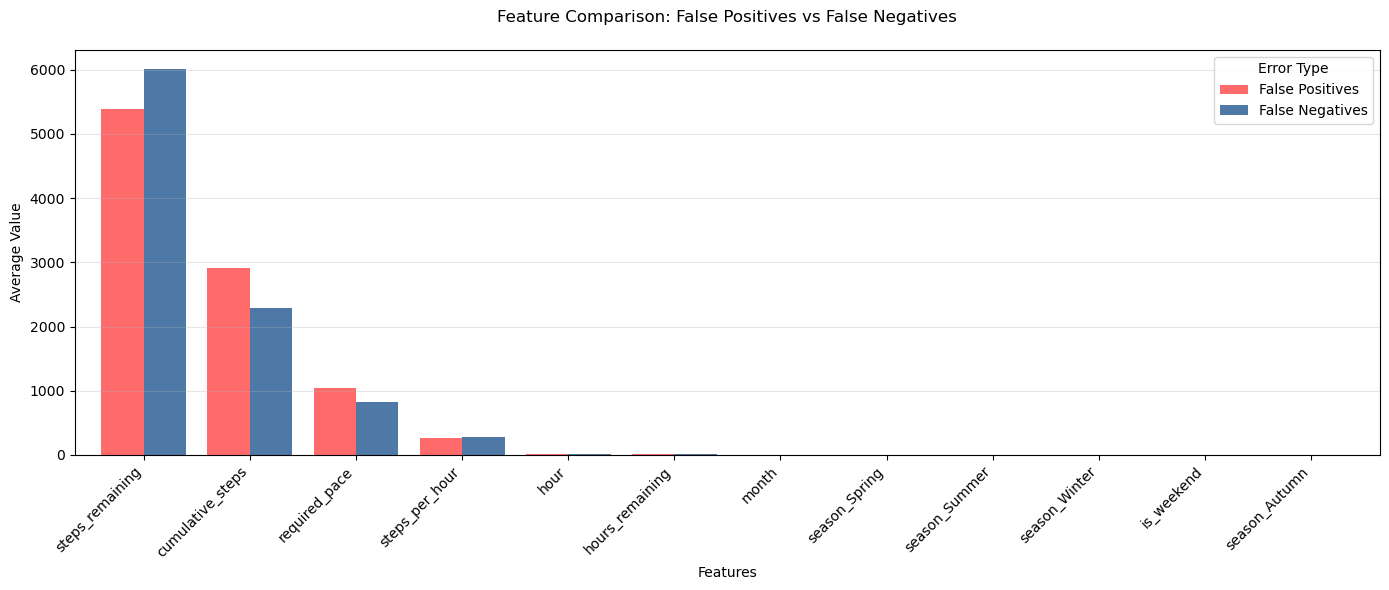

In [218]:
plot_feature_comparison(error_data['comparison_df'])

In [219]:
def plot_feature_differences(comparison_df):
    """Create difference plot between FP and FN averages"""
    plt.figure(figsize=(14, 6))
    comparison_df['Difference'].plot(
        kind='bar', color=np.where(comparison_df['Difference']>0, '#FF6B6B', '#4E79A7')
    )
    plt.title('Feature Differences: FP Average - FN Average', pad=20)
    plt.ylabel('Difference in Average Values')
    plt.xlabel('Features')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

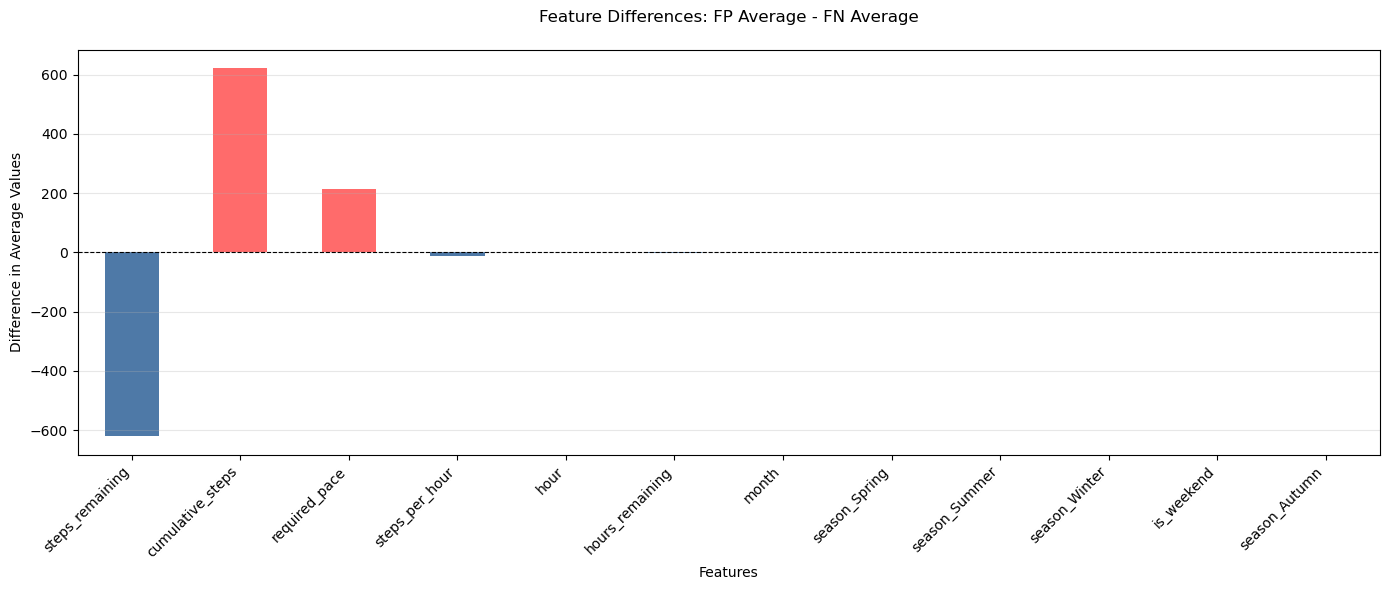

In [220]:
plot_feature_differences(error_data['comparison_df'])

In [221]:
def plot_radar_chart(comparison_df):
    """Create radar chart comparing FP and FN patterns"""
    categories = list(comparison_df.index)[:-1]  # Exclude 'Difference'
    N = len(categories)

    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    # FP values
    values = comparison_df['False Positives'][categories].values.tolist()
    values += values[:1]
    ax.plot(angles, values, color='#FF6B6B', linewidth=2, label='False Positives')
    ax.fill(angles, values, color='#FF6B6B', alpha=0.25)

    # FN values
    values = comparison_df['False Negatives'][categories].values.tolist()
    values += values[:1]
    ax.plot(angles, values, color='#4E79A7', linewidth=2, label='False Negatives')
    ax.fill(angles, values, color='#4E79A7', alpha=0.25)

    # Formatting
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), categories)
    ax.set_rlabel_position(30)
    plt.title('Feature Pattern Comparison: FP vs FN', pad=30, fontsize=14)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

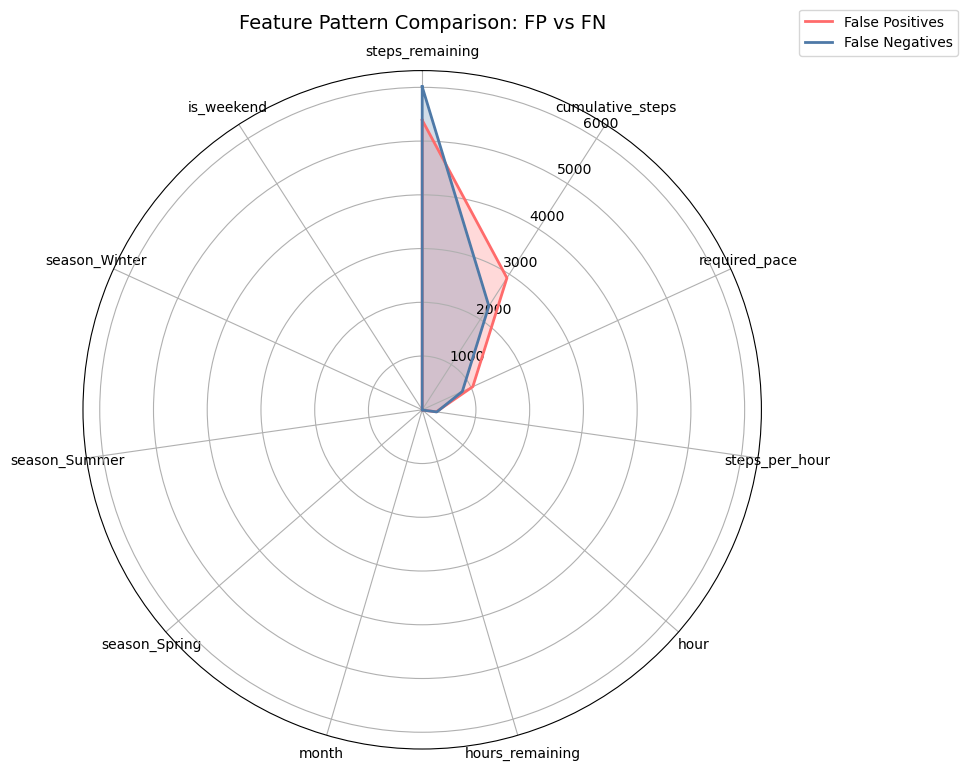

In [222]:
plot_radar_chart(error_data['comparison_df'])

In [223]:
def print_key_insights(comparison_df):
    """Print key insights from the error analysis"""
    print("\n" + "="*50)
    print("KEY INSIGHTS")
    print("="*50)
    print("1. Features with highest FP values:", list(comparison_df['False Positives'].nlargest(3).index))
    print("2. Features with highest FN values:", list(comparison_df['False Negatives'].nlargest(3).index))
    print("3. Most differentiating features:", list(comparison_df['Difference'].abs().nlargest(3).index))
    print("\nTop features with largest differences:")
    print(comparison_df['Difference'].abs().sort_values(ascending=False).head(5))

In [224]:
print_key_insights(error_data['comparison_df'])


KEY INSIGHTS
1. Features with highest FP values: ['steps_remaining', 'cumulative_steps', 'required_pace']
2. Features with highest FN values: ['steps_remaining', 'cumulative_steps', 'required_pace']
3. Most differentiating features: ['cumulative_steps', 'steps_remaining', 'required_pace']

Top features with largest differences:
cumulative_steps    621.608900
steps_remaining     621.608900
required_pace       214.215513
steps_per_hour       11.127000
month                 2.183982
Name: Difference, dtype: float64


In [225]:
# Feature Importance
feature_importances = model.feature_importances_
features = X_train.columns
sorted_idx = feature_importances.argsort()

In [226]:
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)
for i in range(1, len(features) + 1):
    idx = sorted_idx[-i]
    print(f"{i}. {features[idx]} : {feature_importances[idx]:.4f}")


FEATURE IMPORTANCE ANALYSIS
1. cumulative_steps : 0.3112
2. steps_remaining : 0.2868
3. steps_per_hour : 0.2245
4. hours_remaining : 0.0727
5. hour : 0.0542
6. required_pace : 0.0348
7. month : 0.0104
8. season_Winter : 0.0031
9. season_Summer : 0.0014
10. season_Spring : 0.0010
11. season_Autumn : 0.0000
12. is_weekend : 0.0000


In [227]:
def plot_feature_importances(features, importances,
                            fig_size=(10, 8),
                            title='Feature Importances',
                            palette='viridis',
                            label_size=10,
                            value_format='{:.3f}'):
    """
    Displays ALL features without data loss, with anti-overlap formatting.

    Parameters:
    -----------
    features : array-like
        Feature names (e.g., X_train.columns)
    importances : array-like
        Importance scores (e.g., model.feature_importances_)
    fig_size : tuple, optional
        Figure dimensions (width, height)
    title : str, optional
        Plot title
    palette : str, optional
        Color palette name
    label_size : int, optional
        Font size for feature names
    value_format : str, optional
        Format string for importance values
    """
    # Create DataFrame
    df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values('Importance', ascending=True)

    # Create plot with corrected palette handling
    plt.figure(figsize=fig_size)
    ax = sns.barplot(
        x='Importance',
        y='Feature',
        data=df,
        hue='Feature',  # Explicitly map colors to features
        palette=palette,
        orient='h',
        dodge=False,
        saturation=0.8,
        legend=False  # Disable legend since we already have y-axis labels
    )

    # Formatting
    ax.set_title(title, pad=20, fontsize=label_size+2)
    ax.set_xlabel('Importance Score', fontsize=label_size)
    ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=label_size)
    ax.tick_params(axis='x', labelsize=label_size-1)

    # Add value labels
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(
            value_format.format(width),
            xy=(width, p.get_y() + p.get_height()/2),
            xytext=(3, 0),
            textcoords='offset points',
            ha='left',
            va='center',
            fontsize=label_size
        )

    ax.grid(True, axis='x', linestyle=':', alpha=0.4)
    plt.tight_layout()
    plt.show()

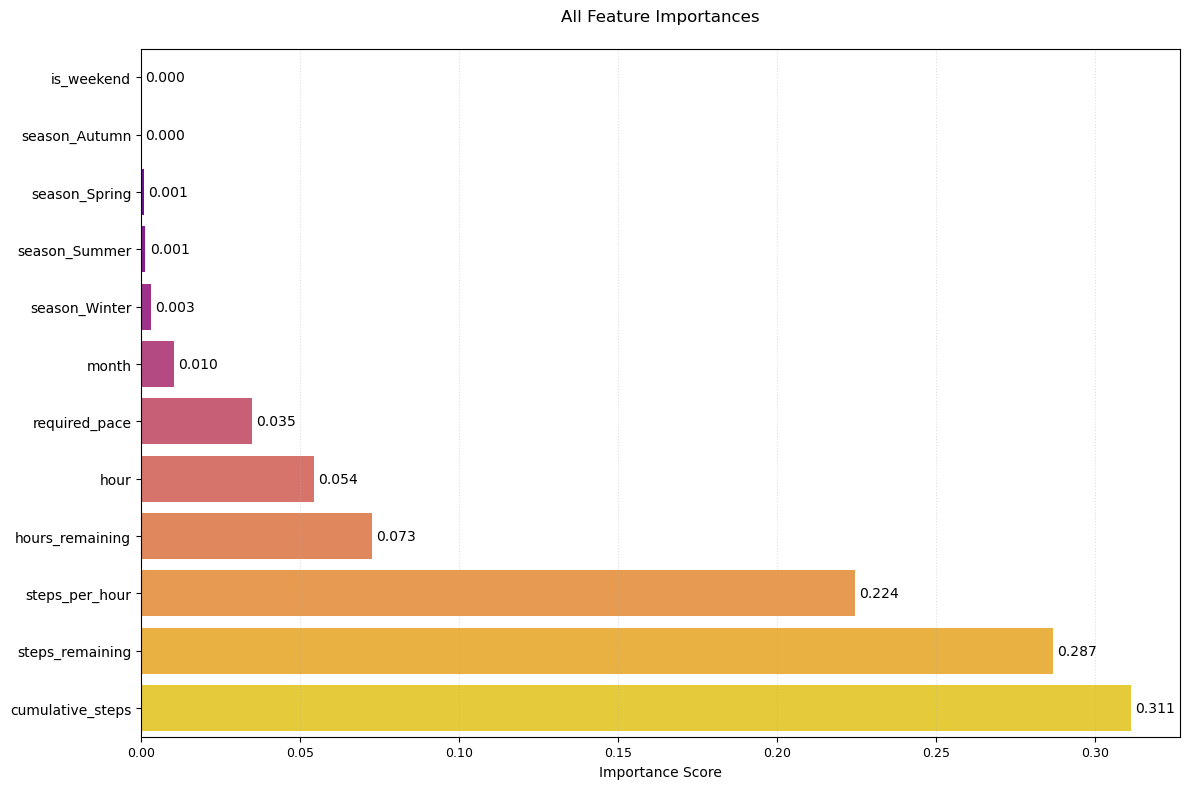

In [228]:
plot_feature_importances(
    features=X_train.columns,
    importances=model.feature_importances_,
    title='All Feature Importances',
    palette='plasma',
    fig_size=(12, 8)  # Slightly wider for better spacing
)

In [229]:
print("Model training and evaluation complete!\n")

Model training and evaluation complete!



## Step 6 : Model Comparison

In [230]:
print("STEP 6: comparing models...")

STEP 6: comparing models...


### 1. Create a model that always predicts the majority class

In [231]:
# Baseline model comparison with label mapping
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

print("\n" + "="*50)
print("BASELINE COMPARISON (Majority Class Predictor)")
print("="*50)
print("Performance of a model that always predicts the most frequent class:")

# Use label_map for target names
target_names = [label_map[0], label_map[1]]  # ["Not Reached", "Reached"]

# Generate and print formatted classification report
report_str = classification_report(
    y_test, 
    dummy_pred, 
    target_names=target_names,
    zero_division=0,
    digits=3
)
print('\n'.join([
    line for line in report_str.split('\n') 
    if 'accuracy' not in line and line.strip()
]))

# Calculate and print performance comparison
baseline_acc = dummy.score(X_test, y_test)
model_acc = accuracy_score(y_test, y_pred)
improvement = model_acc - baseline_acc

print("\n" + "-"*50)
print(f"{'Metric':<25} | {'Value':<10}")
print("-"*50)
print(f"{'Baseline Accuracy':<25} | {baseline_acc:.3f}")
print(f"{'Model Accuracy':<25} | {model_acc:.3f}")
print(f"{'Improvement':<25} | +{improvement:.3f}")
print("="*50 + "\n")

# Optional: Print the actual majority class
print(f"Note: Baseline always predicts '{label_map[y_train.mode()[0]]}'")


BASELINE COMPARISON (Majority Class Predictor)
Performance of a model that always predicts the most frequent class:
              precision    recall  f1-score   support
 Not Reached      0.718     1.000     0.836    429729
     Reached      0.000     0.000     0.000    168771
   macro avg      0.359     0.500     0.418    598500
weighted avg      0.516     0.718     0.600    598500

--------------------------------------------------
Metric                    | Value     
--------------------------------------------------
Baseline Accuracy         | 0.718
Model Accuracy            | 0.969
Improvement               | +0.251

Note: Baseline always predicts 'Not Reached'


### 2. Precision-Recall Comparison Bar Plot

In [232]:
def plot_model_comparison(model_metrics, dummy_metrics, class_labels, figsize=(18, 5)):
    """
    Plot side-by-side comparison of model vs baseline metrics.

    Parameters:
    -----------
    model_metrics : tuple
        (precision, recall, f1) for your model (each should be array-like with per-class scores)
    dummy_metrics : tuple
        (precision, recall, f1) for baseline model
    class_labels : list
        Names of your classes (e.g., ['Negative', 'Positive'])
    figsize : tuple, optional
        Figure dimensions (width, height) in inches
    """
    # Unpack metrics and ensure they're numpy arrays
    model_precision, model_recall, model_f1 = [np.array(x) for x in model_metrics]
    dummy_precision, dummy_recall, dummy_f1 = [np.array(x) for x in dummy_metrics]

    # Check shapes
    for name, vals in zip(['Precision', 'Recall', 'F1'],
                            [model_precision, model_recall, model_f1,
                            dummy_precision, dummy_recall, dummy_f1]):
        if vals.ndim != 1 or len(vals) != len(class_labels):
            raise ValueError(f"{name} metrics must have shape ({len(class_labels)},), got {vals.shape}")

    # Set up plot
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    metrics = ['Precision', 'Recall', 'F1-Score']
    x = np.arange(len(class_labels))
    width = 0.35

    # Plot each metric
    for i, (metric_name, model_vals, dummy_vals) in enumerate(zip(
        metrics,
        [model_precision, model_recall, model_f1],
        [dummy_precision, dummy_recall, dummy_f1]
    )):
        rects1 = ax[i].bar(x - width/2, model_vals, width, label='Model', color='#1f77b4')
        rects2 = ax[i].bar(x + width/2, dummy_vals, width, label='Baseline', color='#ff7f0e')

        ax[i].set_title(metric_name, fontsize=12)
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(class_labels)
        ax[i].legend(fontsize=10)
        ax[i].set_ylim(0, 1.1)
        ax[i].grid(axis='y', alpha=0.3)

        # Add value labels
        for rect in rects1 + rects2:
            height = rect.get_height()
            ax[i].annotate(f'{height:.2f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom',
                            fontsize=9)

    plt.suptitle('Model vs Baseline Performance Comparison', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

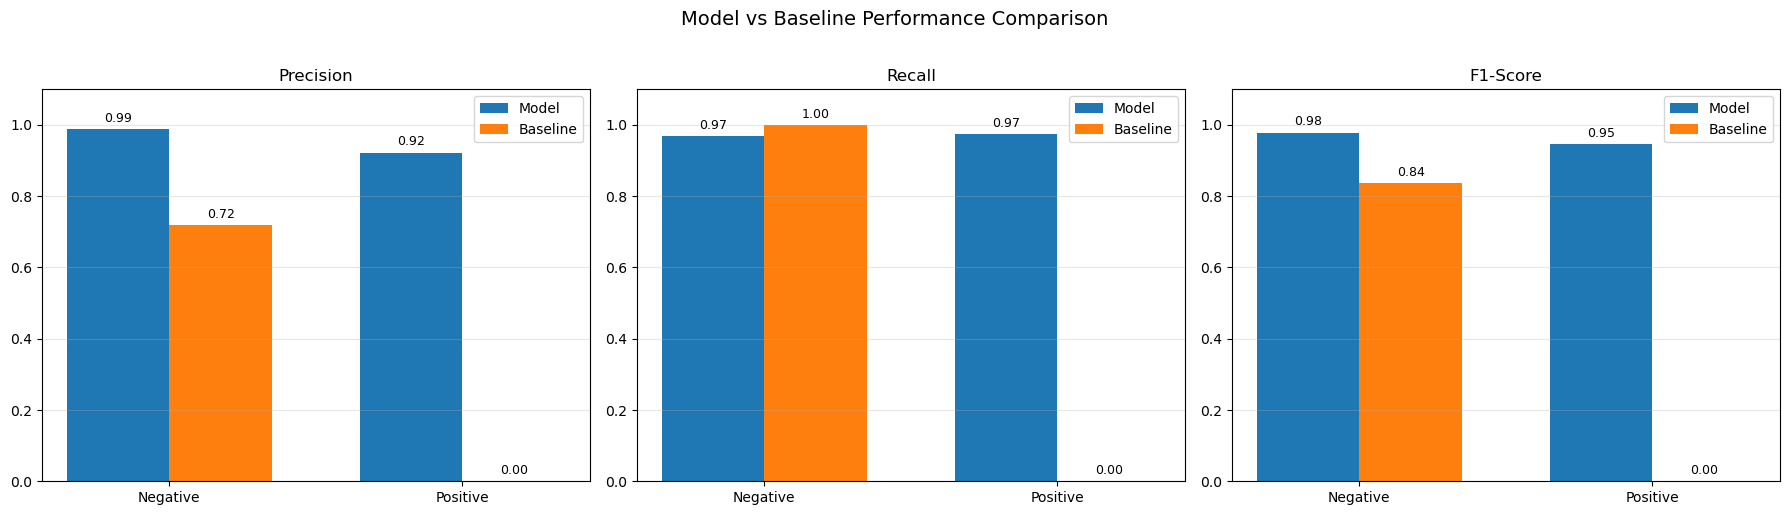

In [233]:
# Calculate per-class metrics for your model
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Calculate per-class metrics for baseline
dummy_precision = precision_score(y_test, dummy_pred, average=None, zero_division=0)
dummy_recall = recall_score(y_test, dummy_pred, average=None, zero_division=0)
dummy_f1 = f1_score(y_test, dummy_pred, average=None, zero_division=0)

# Now call the function
plot_model_comparison(
    model_metrics=(precision, recall, f1),
    dummy_metrics=(dummy_precision, dummy_recall, dummy_f1),
    class_labels=['Negative', 'Positive']
)

### 3. Accuracy Improvement Visualization

In [234]:
def plot_accuracy_comparison(y_true, y_pred, baseline_model, X_test=None,
                            labels=['Baseline', 'Model', 'Improvement'],
                            colors=['red', 'green', 'blue'],
                            figsize=(8, 5), ylim=(0, 1.1)):
    """
    Plot accuracy comparison between baseline model and your model.

    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels from your model
    baseline_model : estimator
        Trained baseline model with .score() method
    X_test : array-like, optional
        Test features (required if baseline_model needs X_test for scoring)
    labels : list, optional
        Labels for the bars (default: ['Baseline', 'Model', 'Improvement'])
    colors : list, optional
        Colors for the bars (default: ['red', 'green', 'blue'])
    figsize : tuple, optional
        Figure size (default: (8, 5))
    ylim : tuple, optional
        Y-axis limits (default: (0, 1.1))
    """
    # Calculate accuracies
    baseline_acc = baseline_model.score(X_test, y_true) if X_test is not None else baseline_model
    model_acc = accuracy_score(y_true, y_pred)
    improvement = model_acc - baseline_acc

    # Create plot
    plt.figure(figsize=figsize)
    bars = plt.bar(labels,
                    [baseline_acc, model_acc, improvement],
                    color=colors)

    # Formatting
    plt.title('Accuracy Comparison', fontsize=14, pad=15)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim(*ylim)
    plt.grid(axis='y', alpha=0.3)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)

    plt.tight_layout()
    plt.show()

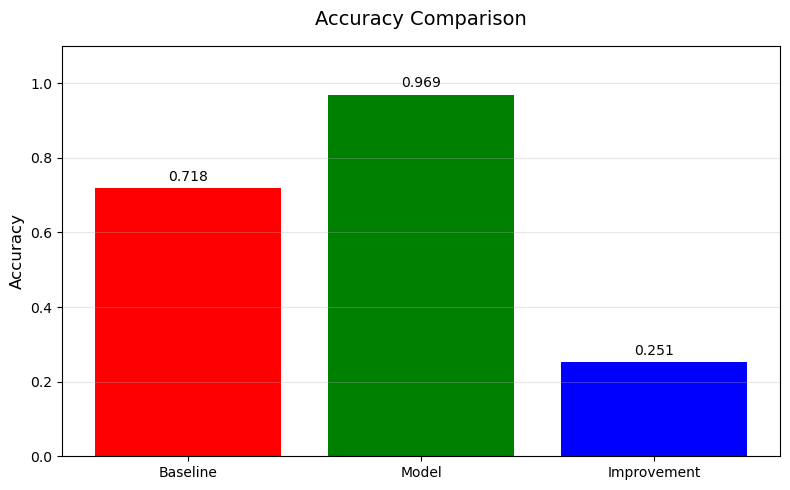

In [235]:
dummy_accuracy = dummy.score(X_test, y_test)
plot_accuracy_comparison(y_test, y_pred, dummy_accuracy)  # Where dummy_accuracy is a float

### 4. Confusion Matrix Comparison

In [236]:
def plot_confusion_matrix_comparison(y_test, y_pred, dummy_pred, label_map, figsize=(12, 5)):
    """
    Plots side-by-side confusion matrices for a model and a baseline model.

    Parameters:
    - y_test: True labels
    - y_pred: Model's predictions
    - dummy_pred: Baseline model's predictions
    - label_map: Dictionary mapping class indices to label names
    - figsize: Tuple specifying figure size (default: (12, 5))
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Model's confusion matrix
    cm_model = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_model, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=[f'Pred {label_map[0]}', f'Pred {label_map[1]}'],
                yticklabels=[f'True {label_map[0]}', f'True {label_map[1]}'])
    ax1.set_title('Model')

    # Baseline model's confusion matrix
    cm_dummy = confusion_matrix(y_test, dummy_pred)
    sns.heatmap(cm_dummy, annot=True, fmt='d', cmap='Reds', ax=ax2,
                xticklabels=[f'Pred {label_map[0]}', f'Pred {label_map[1]}'],
                yticklabels=[f'True {label_map[0]}', f'True {label_map[1]}'])
    ax2.set_title('Baseline Model')

    plt.suptitle('Confusion Matrix Comparison')
    plt.tight_layout()
    plt.show()

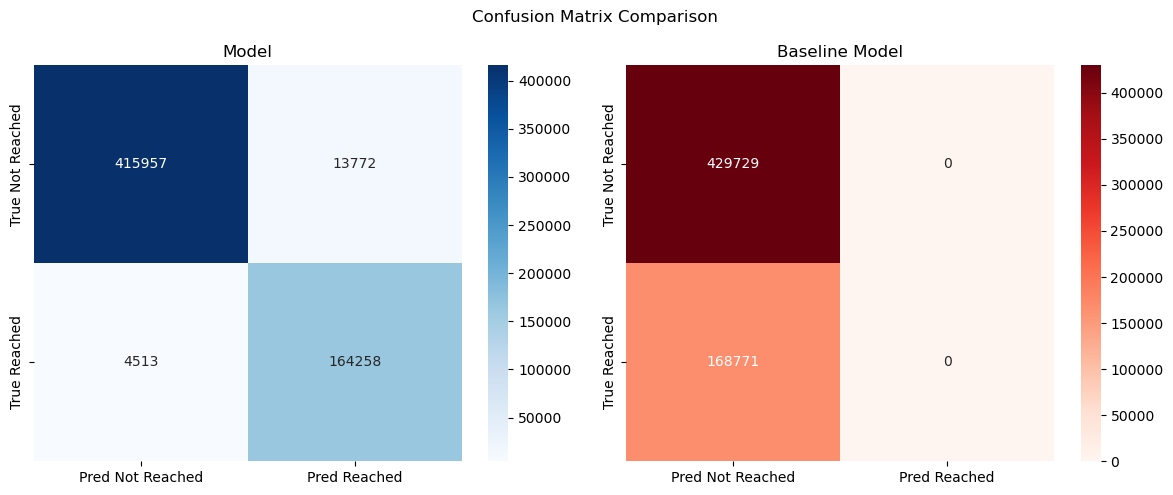

In [237]:
plot_confusion_matrix_comparison(
    y_test=y_test,
    y_pred=y_pred,
    dummy_pred=dummy_pred,
    label_map={0: label_map[0], 1: label_map[1]}
)

### 5. ROC Curve Comparison

In [238]:
def plot_roc_comparison(y_test, model, dummy_model, X_test, figsize=(8, 6)):
    """
    Plots ROC curves comparing the model against a baseline model.

    Parameters:
    - y_test: True labels
    - model: Your trained model (must have predict_proba method)
    - dummy_model: Your baseline model (must have predict_proba method)
    - X_test: Test features
    - figsize: Tuple specifying figure size (default: (8, 6))
    """
    try:
        # Get probabilities for positive class
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # ROC Curve for main model
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        # ROC Curve for dummy model
        dummy_proba = np.full_like(y_test, dummy_model.predict_proba(X_test)[0, 1])
        dummy_fpr, dummy_tpr, _ = roc_curve(y_test, dummy_proba)
        dummy_auc = auc(dummy_fpr, dummy_tpr)

        # Plotting
        plt.figure(figsize=figsize)
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'Model (AUC = {roc_auc:.2f})')
        plt.plot(dummy_fpr, dummy_tpr, color='blue', lw=2, linestyle='--',
                label=f'Baseline (AUC = {dummy_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    except AttributeError:
        print("ROC curve not available - model needs to have predict_proba method")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

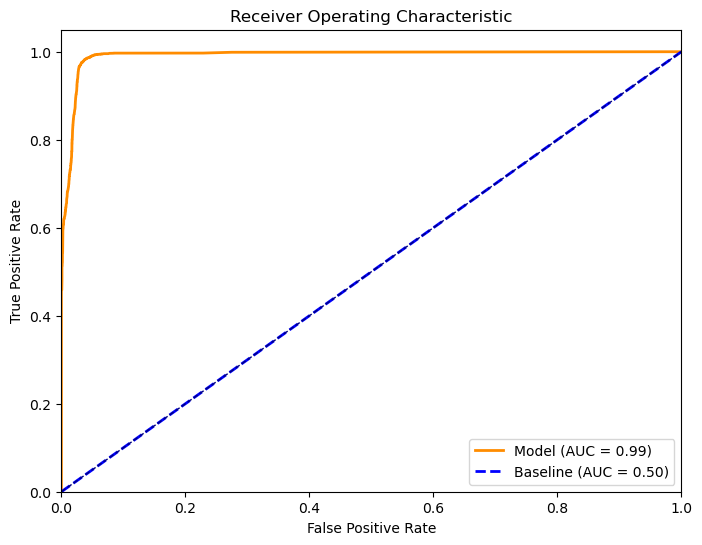

In [239]:
plot_roc_comparison(
    y_test=y_test,
    model=model,
    dummy_model=dummy,
    X_test=X_test
)

### 6. Precision-Recall Curve Comparison

In [240]:
def plot_pr_comparison(y_test, model, dummy_model, X_test, figsize=(8, 6)):
    """
    Plots Precision-Recall curves comparing the model against a baseline model.

    Parameters:
    - y_test: True labels (array-like)
    - model: Your trained classifier with predict_proba() method
    - dummy_model: Your baseline classifier with predict_proba() method
    - X_test: Test features (array-like)
    - figsize: Figure size (default: (8, 6))
    """
    try:
        # Get probabilities for positive class
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        dummy_proba = np.full_like(y_test, dummy_model.predict_proba(X_test)[0, 1])

        # Precision-Recall curve for Model
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)

        # Precision-Recall curve for dummy model
        dummy_precision, dummy_recall, _ = precision_recall_curve(y_test, dummy_proba)
        dummy_pr_auc = auc(dummy_recall, dummy_precision)

        # Plotting
        plt.figure(figsize=figsize)
        plt.plot(recall, precision, color='darkorange', lw=2,
                label=f'Model (AUC = {pr_auc:.2f})')
        plt.plot(dummy_recall, dummy_precision, color='blue', lw=2, linestyle='--',
                label=f'Baseline (AUC = {dummy_pr_auc:.2f})')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="upper right")
        plt.show()

    except AttributeError:
        print("PR curve not available - models need predict_proba() method")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

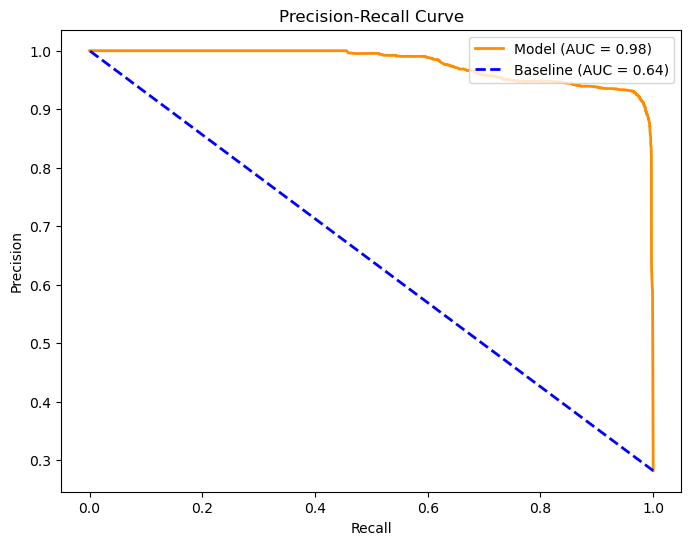

In [241]:
plot_pr_comparison(
    y_test=y_test,
    model=model,
    dummy_model=dummy,
    X_test=X_test
)

### 7. Class Distribution and Prediction Comparison

In [242]:
def plot_class_distribution_comparison(y_test, y_pred, dummy_pred, label_map, figsize=(10, 6)):
    """
    Plots a comparison of actual vs predicted class distributions between model and baseline.

    Parameters:
    - y_test: True labels (array-like)
    - y_pred: Model predictions (array-like)
    - dummy_pred: Baseline model predictions (array-like)
    - label_map: Dictionary mapping class indices to label names (e.g., {0: 'Negative', 1: 'Positive'})
    - figsize: Figure size (default: (10, 6))
    """
    # Prepare the data
    total = len(y_test)
    data = pd.DataFrame({
        'Class': [label_map[0], label_map[1]] * 3,
        'Count': [
            sum(y_test == 0), sum(y_test == 1),  # Actual counts
            sum(y_pred == 0), sum(y_pred == 1),  # Model predictions
            sum(dummy_pred == 0), sum(dummy_pred == 1)  # Baseline predictions
        ],
        'Type': ['Actual']*2 + ['Model']*2 + ['Baseline']*2
    })

    # Calculate percentages
    data['Percentage'] = (data['Count'] / total * 100).round(1)

    # Print the dataframe
    print("Class Distribution Data:")
    print(data.to_string(index=False))
    print("\n")

    # Create the plot
    plt.figure(figsize=figsize)
    palette = {'Actual': 'blue', 'Model': 'green', 'Baseline': 'red'}
    ax = sns.barplot(x='Class', y='Count', hue='Type', data=data, palette=palette)

    # Add value labels, including for 0%
    for (class_name, type_name, count, percentage) in zip(data['Class'], data['Type'], data['Count'], data['Percentage']):
        # Find the X position of the bar group for this class
        x_positions = list(data['Class']).index(class_name)  # 0 for first class, 1 for second class

        offset = 0.27
        # Find the exact position based on Type (Actual, Model, Baseline)
        type_offset = {'Actual': -offset, 'Model': 0, 'Baseline': offset}
        x = x_positions + type_offset[type_name]

        # Place the annotation
        ax.annotate(f"{count} | {percentage}%",
                    (x, max(count, 0.1)),  # max(count, 0.1) to ensure 0 is visible
                    ha='center', va='bottom',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=10)

    plt.title('Comparison of Actual vs Predicted Class Distributions')
    plt.ylabel('Count')
    plt.xlabel('Class')
    plt.legend(title='Distribution Type')
    plt.tight_layout()
    plt.show()

Class Distribution Data:
      Class  Count     Type  Percentage
Not Reached 429729   Actual        71.8
    Reached 168771   Actual        28.2
Not Reached 420470    Model        70.3
    Reached 178030    Model        29.7
Not Reached 598500 Baseline       100.0
    Reached      0 Baseline         0.0




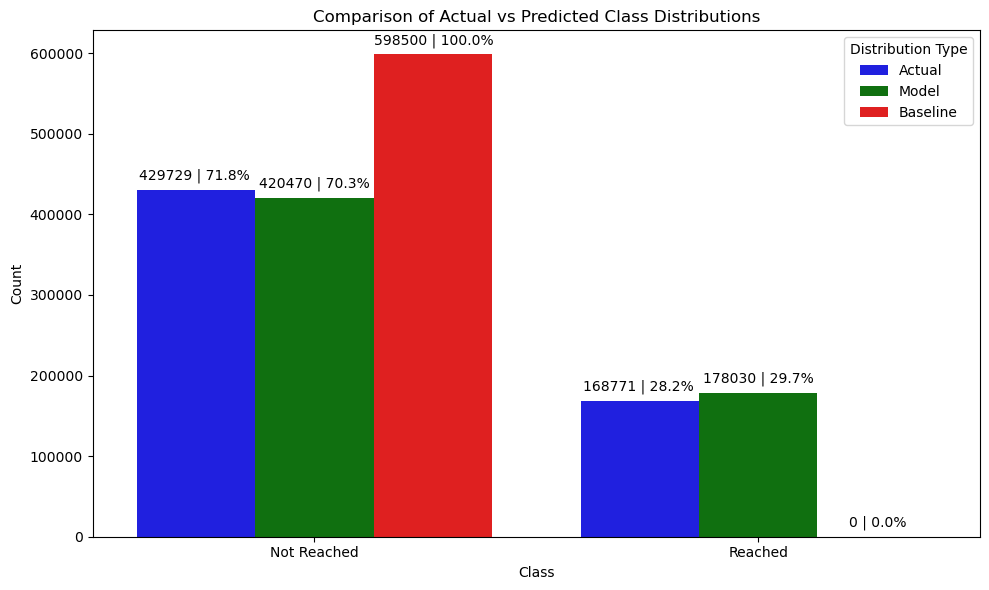

In [243]:
plot_class_distribution_comparison(
    y_test=y_test,
    y_pred=y_pred,
    dummy_pred=dummy_pred,
    label_map={0: label_map[0], 1: label_map[1]}
)

In [244]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_stacked_class_distribution(y_test, y_pred, dummy_pred, label_map, figsize=(12, 6)):
    """
    Plots a stacked bar chart comparing actual vs predicted class distributions.

    Parameters:
    - y_test: True labels (array-like)
    - y_pred: Model predictions (array-like)
    - dummy_pred: Baseline model predictions (array-like)
    - label_map: Dictionary mapping class indices to label names (e.g., {0: 'Negative', 1: 'Positive'})
    - figsize: Figure size (default: (12, 6))
    """
    # Prepare the data
    total = len(y_test)
    data = pd.DataFrame({
        'Class': [label_map[0], label_map[1]] * 3,
        'Count': [
            sum(y_test == 0), sum(y_test == 1),  # Actual counts
            sum(y_pred == 0), sum(y_pred == 1),  # Model predictions
            sum(dummy_pred == 0), sum(dummy_pred == 1)  # Baseline predictions
        ],
        'Type': ['Actual']*2 + ['Model']*2 + ['Baseline']*2
    })

    # Pivot the data for stacked plot
    pivot_data = data.pivot(index='Type', columns='Class', values='Count')

    # Create the plot
    ax = pivot_data.plot(kind='bar', stacked=True, figsize=figsize,
                        color=['tab:blue', 'tab:orange'],
                        edgecolor='white', linewidth=0.5)

    # Add value labels
    for container in ax.containers:
        for p in container:
            width, height = p.get_width(), p.get_height()
            if height > 0:
                x, y = p.get_xy()
                ax.text(x + width/2, y + height/2,
                        f"{int(height)} | {height/total*100:.1f}%",
                        ha='center', va='center',
                        color='white' if height > total*0.3 else 'black')

    plt.title('Stacked Class Distribution: Actual vs Predictions', pad=20)
    plt.ylabel('Count')
    plt.xlabel('')
    plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

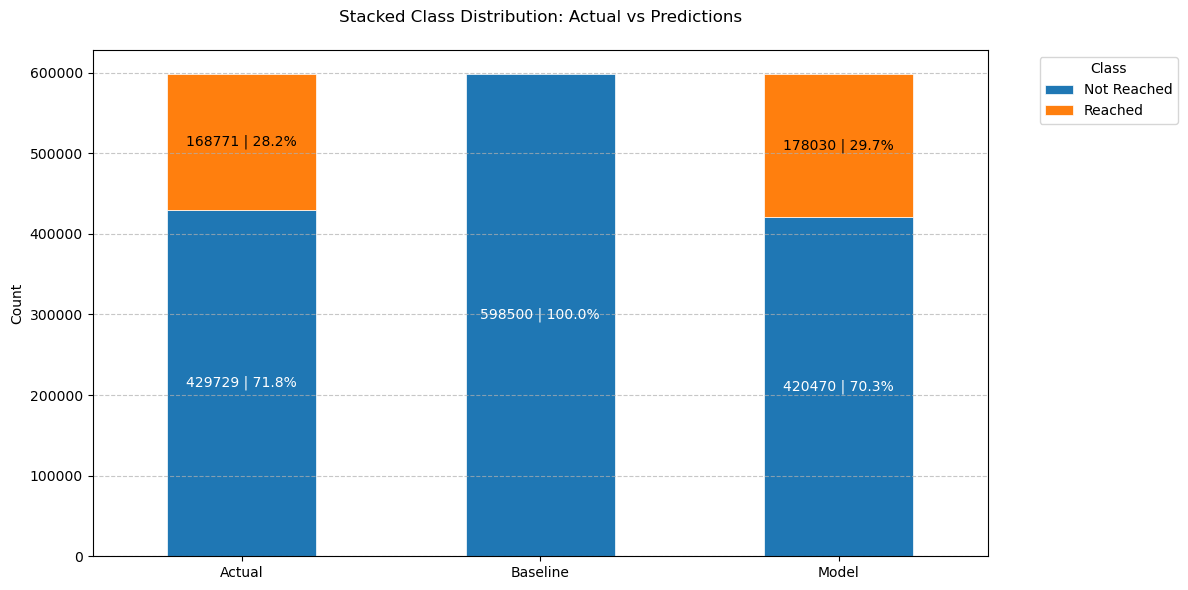

In [245]:
plot_stacked_class_distribution(
    y_test=y_test,
    y_pred=y_pred,
    dummy_pred=dummy_pred,
    label_map={0: label_map[0], 1: label_map[1]}
)

In [246]:
print("Model comparison finished!\n")

Model comparison finished!



## Step 7: Prediction Function

In [247]:
print("STEP 7: Creating prediction function...")

STEP 7: Creating prediction function...


In [265]:
def predict_for_user():
    print("\nPredict whether you will reach your daily step goal:")

    try:
        current_date = "2025-04-01" #input("\nEnter current date (YYYY-MM-DD): ")
        current_time = "14:51" #input("Enter current time (HH:MM): ")
        current_steps = float(input("Current cumulative steps: "))

        hour = int(current_time.split(':')[0])
        if hour < 0 or hour > 23:
            raise ValueError("Hour must be between 0 and 23")
        if current_steps < 0:
            raise ValueError("Steps must be positive")

        date_obj = pd.to_datetime(current_date)
        season = get_season(date_obj)
        is_weekend = date_obj.weekday() >= 5

        user_data = pd.DataFrame({
            'hour': [hour],
            'is_weekend': [int(is_weekend)],
            'cumulative_steps': [current_steps],
            'steps_per_hour': [current_steps / (hour + 1)],
            'steps_remaining': [(overall_avg_steps * 60 * 24) - current_steps],
            'hours_remaining': [18 - hour],
            'required_pace': [((overall_avg_steps * 60 * 24) - current_steps) / (18 - hour + 0.1)],
            'season_Spring': [1 if season == 'Spring' else 0],
            'season_Summer': [1 if season == 'Summer' else 0],
            'season_Autumn': [1 if season == 'Autumn' else 0],
            'season_Winter': [1 if season == 'Winter' else 0],
            'month': [date_obj.month]
        })

        proba = model.predict_proba(user_data[features])[0][1]

        daily_goal = overall_avg_steps * 60 * 24
        progress_ratio = current_steps / daily_goal
        time_ratio = hour / 18

        prediction_threshold = 0.5 - (0.3 * (1 - time_ratio))
        prediction = proba >= prediction_threshold

        print(f"\nPrediction for {current_date} at {current_time}:")
        print(f"- Current: {current_steps:.0f}/{daily_goal:.0f} ({progress_ratio:.1%})")
        print(f"- Time elapsed: {time_ratio:.1%} of day")
        print(f"- Prediction: {'WILL REACH' if prediction else 'WILL NOT REACH'}")
        print(f"- Confidence: {proba:.1%}")

        if hour < 18:
            remaining_hours = 18 - hour
            needed_steps = max(daily_goal - current_steps, 0)
            if remaining_hours > 0:
                hourly_pace = needed_steps / remaining_hours
                print(f"\nTo reach your goal by 18:00:")
                print(f"- Needed: {needed_steps:.0f} more steps")
                print(f"- Required pace: {hourly_pace:.0f} steps/hour")

                if hourly_pace > 1500:
                    print("- Activity suggestion: Vigorous walk + jogging")
                elif hourly_pace > 1000:
                    print("- Activity suggestion: Brisk walking")
                else:
                    print("- Activity suggestion: Leisurely walking")

    except Exception as e:
        print(f"\nError: {str(e)}")
        print("Please try again with valid inputs.")

In [273]:
print("\nStep Goal Prediction System")
print("---------------------------")
print(f"Based on average goal: {overall_avg_steps * 60 * 24:.0f} steps per day")
predict_for_user()

print("\nAnalysis complete!")


Step Goal Prediction System
---------------------------
Based on average goal: 8307 steps per day

Predict whether you will reach your daily step goal:

Prediction for 2025-04-01 at 14:51:
- Current: 2020/8307 (24.3%)
- Time elapsed: 77.8% of day
- Prediction: WILL REACH
- Confidence: 66.7%

To reach your goal by 18:00:
- Needed: 6287 more steps
- Required pace: 1572 steps/hour
- Activity suggestion: Vigorous walk + jogging

Analysis complete!
